# Voltix: A smart short-term energy predictor

### MDA2410A | MDA-O | PF - Final Project

By: 
- Oscar Pauly
- Matías Alucema
- Ander Puente

## Introduction

This report documents the development and results of a short-term energy consumption forecasting pipeline using the XGBoost machine learning algorithm. The project focuses on predicting residential electricity demand at 15-minute intervals for the next 48 hours, integrating historical consumption and weather data.

The pipeline is implemented entirely in Python and structured in modular phases—from data loading and feature engineering to model training, evaluation, and deployment. External data sources such as OpenWeather and eGauge APIs are used to enrich the dataset and ensure real-time applicability.

**Objective**

The main objective is to generate accurate and explainable short-term energy consumption forecasts that can support residential and small commercial users in energy management, system sizing, and load balancing decisions. The model aims to anticipate usage patterns based on past consumption trends and weather conditions, enabling proactive decision-making and integration with cloud-based dashboards.

**Contents**

The project is divided into phases, each one with a specific goal:

1. Phase 1 – Data Loading & Cleaning
2. Phase 2 – Feature Engineering
3. Phase 3 – Preprocessing
4. Phase 4 – Train/Test Split
5. Phase 5 – Model Training with XGBoost
6. Phase 6 – Model Evaluation
7. Phase 7 – 48-Hour Forecasting
8. Phase 8 – Uploading to Google Cloud Storage (GCS)

## Phase 1 – Data Loading & Cleaning

### Required imports and functions

This section includes the package installations, library imports and function definitions required to run the project:

In [1]:
# ──────────────────────────────
# Core dependencies
# ──────────────────────────────
#pip install egauge-python
#pip install gcsfs
#pip install tqdm
#pip install pyarrow

# ──────────────────────────────
# Additional required dependencies
# ──────────────────────────────
#pip install xgboost
#pip install scikit-learn
#pip install matplotlib
#pip install pandas
#pip install numpy
#pip install pytz
#pip install requests

In [28]:
# ──────────────────────────────
# Standard Library Imports
# ──────────────────────────────
import os
import json
from datetime import datetime, timedelta, timezone

# ──────────────────────────────
# Data Processing
# ──────────────────────────────
import numpy as np
import pandas as pd

# ──────────────────────────────
# Machine Learning
# ──────────────────────────────
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import joblib

# ──────────────────────────────
# Visualization
# ──────────────────────────────
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown

# ──────────────────────────────
# APIs and Time Handling
# ──────────────────────────────
import requests
import pytz

# ──────────────────────────────
# eGauge API
# ──────────────────────────────
from egauge import webapi
from egauge.webapi.device import Register

# ──────────────────────────────
# Google Cloud Integration
# ──────────────────────────────
from gcsfs import GCSFileSystem

# ──────────────────────────────
# Progress Display
# ──────────────────────────────
from tqdm import tqdm

# ──────────────────────────────
# File Format Support
# ──────────────────────────────
import pyarrow as pa
import pyarrow.parquet as pq

# Historical data folder paths
file_energy = "data/residencial_2020_2025.csv"
file_weather = "data/residencial_clima_2020_2025.json"

In [33]:
# ──────────────────────────────
# Phase 1: Data Loading and Cleaning
# ──────────────────────────────

def load_energy_data(csv_path):
    """
    Loads the energy consumption CSV and parses datetime column.
    Keeps only 'Date & Time' and 'Usage [kW]'.
    """
    df = pd.read_csv(csv_path, usecols=["Date & Time", "Usage [kW]"])
    df.rename(columns={"Usage [kW]": "Usage_kW"}, inplace=True)
    df["Date & Time"] = pd.to_datetime(df["Date & Time"])
    df.sort_values("Date & Time", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def load_weather_data(json_path):
    """
    Parses weather data from OpenWeather JSON format (list of dicts).
    Extracts datetime and relevant weather features into a flat DataFrame.
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    records = []
    for entry in data:
        main = entry.get("main", {})
        clouds = entry.get("clouds", {})
        wind = entry.get("wind", {})
        dt_iso = entry.get("dt_iso", "").split(" +")[0]  # Remove timezone info if present

        if dt_iso:  # only include records with valid timestamps
            records.append({
                "Date & Time": pd.to_datetime(dt_iso),
                "temp": main.get("temp"),
                "feels_like": main.get("feels_like"),
                "pressure": main.get("pressure"),
                "humidity": main.get("humidity"),
                "dew_point": main.get("dew_point"),
                "cloud_coverage": clouds.get("all"),
                "wind_speed": wind.get("speed"),
                "wind_deg": wind.get("deg")
            })

    df_weather = pd.DataFrame(records)
    df_weather.dropna(subset=["Date & Time"], inplace=True)
    df_weather.sort_values("Date & Time", inplace=True)
    df_weather.reset_index(drop=True, inplace=True)
    
    return df_weather


def merge_energy_weather(df_energy, df_weather):
    """
    Merges energy and weather data on 'Date & Time' with forward fill for missing weather values.
    Assumes weather is less granular than energy data.
    """
    df = pd.merge_asof(df_energy, df_weather, on="Date & Time", direction="backward")
    df.fillna(method="ffill", inplace=True)
    return df

# ──────────────────────────────
# Phase 2: Feature Engineering
# ──────────────────────────────

def engineer_features(df):
    """
    Adds temporal, lag, rolling, cyclic, and night indicator features.
    Normalizes 'Usage_kW' as 'Usage_kW_norm'.
    """
    df = df.copy()

    # Time-based features
    df["hour"] = df["Date & Time"].dt.hour
    df["minute"] = df["Date & Time"].dt.minute
    df["dayofweek"] = df["Date & Time"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)
    
    # Cyclical time encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # Night indicator
    df["is_night"] = df["hour"].apply(lambda h: 1 if h < 6 or h >= 22 else 0)

    # Lag features
    lag_steps = [1, 4, 12, 96, 192, 672]  # 15m, 1h, 3h, 1d, 2d, 1w
    for lag in lag_steps:
        df[f"lag_{lag}"] = df["Usage_kW"].shift(lag)

    # Rolling statistics
    rolling_windows = [4, 12, 96, 192, 672]
    for window in rolling_windows:
        df[f"rolling_mean_{window}"] = df["Usage_kW"].shift(1).rolling(window).mean()
        df[f"rolling_std_{window}"] = df["Usage_kW"].shift(1).rolling(window).std()

    # Normalize target
    usage_min = df["Usage_kW"].min()
    usage_max = df["Usage_kW"].max()
    df["Usage_kW_norm"] = (df["Usage_kW"] - usage_min) / (usage_max - usage_min)

    return df, usage_min, usage_max


# ──────────────────────────────
# Phase 3: Preprocessing
# ──────────────────────────────

def preprocess_for_training(df):
    """
    Removes rows with NaNs (from lags and rolling features),
    and returns feature matrix X and target y for modeling.
    """
    df_clean = df.dropna().copy()

    target_col = "Usage_kW_norm"
    ignore_cols = ["Date & Time", "Usage_kW", target_col]
    feature_cols = [col for col in df_clean.columns if col not in ignore_cols]

    X = df_clean[feature_cols]
    y = df_clean[target_col]

    print("\nPreprocessing complete")
    print("Clean shape:", df_clean.shape)
    print("Feature matrix shape:", X.shape)
    print("Target vector shape:", y.shape)

    return X, y, df_clean

# ──────────────────────────────
# Phase 4: Train/Test Split by Custom Date
# ──────────────────────────────

def split_by_date(df, start_date, end_date):
    """
    Filters the dataframe between two datetime strings [start_date, end_date).
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    return df[(df["Date & Time"] >= start) & (df["Date & Time"] < end)].copy()

def split_train_test(df_clean, train_range, test_range):
    """
    Splits dataset by custom train and test date ranges.
    """
    df_train = split_by_date(df_clean, *train_range)
    df_test = split_by_date(df_clean, *test_range)

    X_train = df_train.drop(columns=["Date & Time", "Usage_kW", "Usage_kW_norm"])
    y_train = df_train["Usage_kW_norm"]
    X_test = df_test.drop(columns=["Date & Time", "Usage_kW", "Usage_kW_norm"])
    y_test = df_test["Usage_kW_norm"]

    print("\nCustom train/test split complete")
    print("Train shape:", X_train.shape)
    print("Test shape:", X_test.shape)
    print("Train period:", df_train["Date & Time"].min(), "to", df_train["Date & Time"].max())
    print("Test period:", df_test["Date & Time"].min(), "to", df_test["Date & Time"].max())

    return X_train, y_train, X_test, y_test, df_train, df_test

# ──────────────────────────────
# Phase 5: Train XGBoost model
# ──────────────────────────────

def train_xgboost_model(X_train, y_train, usage_min, usage_max, n_splits=5):
    """
    Trains an XGBoost regressor with TimeSeriesSplit, GridSearchCV and EarlyStopping.
    Saves the best model and plots training history and feature importance.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0, eval_metric="rmse")

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=tscv,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("\nBest Parameters:", grid_search.best_params_)

    # Save model
    joblib.dump(best_model, "xgboost_best_model.joblib")
    print("Best model saved as 'xgboost_best_model.joblib'")

    # Plot CV performance across parameter combinations
    results = grid_search.cv_results_
    mean_train_score = -np.array(results['mean_train_score'])
    mean_test_score = -np.array(results['mean_test_score'])

    plt.figure(figsize=(10, 5))
    plt.plot(mean_train_score, label='Train RMSE')
    plt.plot(mean_test_score, label='CV Mean RMSE')
    plt.title('Grid Search Cross-Validation Performance')
    plt.xlabel('Parameter combination index')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Access and plot evaluation metrics from best model
    if hasattr(best_model, 'evals_result_'):
        evals_result = best_model.evals_result()
        if 'validation_0' in evals_result:
            plt.figure(figsize=(10, 5))
            plt.plot(evals_result['validation_0']['rmse'], label='Training RMSE')
            if 'validation_1' in evals_result:
                plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE')
            plt.title("Training History")
            plt.xlabel("Epoch")
            plt.ylabel("RMSE")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Plot feature importance
    xgb.plot_importance(best_model, max_num_features=30, height=0.5)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

    return best_model

# ──────────────────────────────
# Phase 6: Evaluation on Test Set
# ──────────────────────────────

def evaluate_on_test_months(model, X_test, y_test, df_test, usage_min, usage_max):
    """
    Plots actual vs predicted for each month in test set.
    Calculates and displays MAE and RMSE per month.
    Prints average and maximum MAE/RMSE across all months.
    """
    # Denormalize predictions
    y_pred = model.predict(X_test)
    y_pred_real = y_pred * (usage_max - usage_min) + usage_min
    y_test_real = y_test * (usage_max - usage_min) + usage_min

    df_plot = df_test.copy()
    df_plot["Predicted [kW]"] = y_pred_real
    df_plot["Actual [kW]"] = y_test_real
    df_plot["Month"] = df_plot["Date & Time"].dt.to_period("M")

    mae_list = []
    rmse_list = []

    months = df_plot["Month"].unique()

    for month in months:
        df_month = df_plot[df_plot["Month"] == month]
        mae = mean_absolute_error(df_month["Actual [kW]"], df_month["Predicted [kW]"])
        rmse = mean_squared_error(df_month["Actual [kW]"], df_month["Predicted [kW]"]) ** 0.5

        mae_list.append(mae)
        rmse_list.append(rmse)

        plt.figure(figsize=(12, 4))
        plt.plot(df_month["Date & Time"], df_month["Actual [kW]"], label="Actual [kW]", alpha=0.7)
        plt.plot(df_month["Date & Time"], df_month["Predicted [kW]"], label="Predicted [kW]", alpha=0.7)
        plt.title(f"{month} — MAE: {mae:.2f} kW, RMSE: {rmse:.2f} kW")
        plt.xlabel("Date")
        plt.ylabel("Consumption [kW]")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Print summary statistics
    print(f"\nTest Set Evaluation Summary:")
    print(f"Average MAE: {np.mean(mae_list):.2f} kW")
    print(f"Maximum MAE: {np.max(mae_list):.2f} kW")
    print(f"Average RMSE: {np.mean(rmse_list):.2f} kW")
    print(f"Maximum RMSE: {np.max(rmse_list):.2f} kW")

# ──────────────────────────────
# Phase 7: 48h forecast
# ──────────────────────────────

def get_weather_forecast(lat, lon, api_key, units='metric', lang='en'):
    """
    Queries OpenWeather One Call API 3.0 for minutely, hourly, and daily forecasts.
    """
    url = "https://api.openweathermap.org/data/3.0/onecall"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': units,
        'lang': lang
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error {response.status_code}: {response.text}")

def preparar_clima_openweather_hourly(hourly_data):
    """
    Converts OpenWeather hourly forecast into DataFrame with datetime and flat features.
    """
    df = pd.DataFrame(hourly_data)
    df["Date & Time"] = pd.to_datetime(df["dt"], unit="s")
    df["temp"] = df["temp"]
    df["humidity"] = df["humidity"]
    df["clouds"] = df["clouds"]
    df["weather_main"] = df["weather"].apply(lambda x: x[0]["main"] if isinstance(x, list) and len(x) > 0 else None)
    dummies = pd.get_dummies(df["weather_main"], prefix="weather")
    df = pd.concat([df, dummies], axis=1)
    columnas_finales = ["Date & Time", "temp", "humidity", "clouds"] + list(dummies.columns)
    df_result = df[columnas_finales].copy()
    df_result.set_index("Date & Time", inplace=True)
    return df_result

def fill_missing_weather(df_forecast, df_hist_weather, weather_features):
    def ensure_datetime_index(df):
        if not isinstance(df.index, pd.DatetimeIndex):
            if "Date & Time" in df.columns:
                df = df.set_index("Date & Time")
            df.index = pd.to_datetime(df.index)
        return df

    print("Step 1: Ensuring datetime index for historical weather data...")
    df_hist = ensure_datetime_index(df_hist_weather.copy())
    print("   ➤ df_hist shape:", df_hist.shape)
    print("   ➤ Historical weather range:", df_hist.index.min(), "to", df_hist.index.max())
    df_hist["month"] = df_hist.index.month
    df_hist["hour"] = df_hist.index.hour

    print("Step 2: Ensuring datetime index for forecast weather data...")
    df = ensure_datetime_index(df_forecast.copy())
    print("   ➤ df_forecast shape before fill:", df.shape)
    print("   ➤ Forecast weather range:", df.index.min(), "to", df.index.max())
    df["month"] = df.index.month
    df["hour"] = df.index.hour

    available_features = [f for f in weather_features if f in df.columns and f in df_hist.columns]
    missing_features = [f for f in weather_features if f not in available_features]

    if missing_features:
        print(f"⚠️ Warning: Missing weather features not available for fill: {missing_features}")
    else:
        print(f"All {len(available_features)} expected weather features available for filling.")

    avg_by_mh = df_hist.groupby(["month", "hour"])[available_features].mean()

    if df.index.max() is pd.NaT or df.index.min() is pd.NaT:
        print("❌ ERROR: Forecast index contains NaT values")
        raise ValueError("Forecast index contains only NaT. Check weather forecast input.")

    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="1h")
    print("Reindexing forecast from", full_range.min(), "to", full_range.max(), f"({len(full_range)} timestamps)")
    df = df.reindex(full_range)
    print("   ➤ df shape after reindex:", df.shape)

    df["month"] = df.index.month
    df["hour"] = df.index.hour

    for feature in available_features:
        missing = df[feature].isna()
        print(f"Filling {missing.sum()} missing values for '{feature}'...")
        df.loc[missing, feature] = df.loc[missing].apply(
            lambda row: avg_by_mh.loc[(row["month"], row["hour"])][feature]
            if (row["month"], row["hour"]) in avg_by_mh.index and feature in avg_by_mh.columns else np.nan,
            axis=1
        )

    print("Weather forecast filling complete.")
    print("   ➤ Final df shape:", df.shape)
    return df.drop(columns=["month", "hour"])

def preparar_df_last_known(df_consumo, target_col="Usage_KW", buffer_minutes=1440, max_attempts=5):
    """
    Tries increasing the time window until a valid feature DataFrame can be generated.
    """
    df = df_consumo.copy()
    df["Date & Time"] = pd.to_datetime(df["Date & Time"])
    df = df.sort_values("Date & Time")

    for attempt in range(max_attempts):
        cutoff = df["Date & Time"].max() - pd.Timedelta(minutes=buffer_minutes)
        df_window = df[df["Date & Time"] > cutoff]

        print(f"Attempt {attempt+1}: Buffer {buffer_minutes} minutes — rows: {len(df_window)}")
        
        if not df_window.empty:
            df_feat, _, _ = engineer_features(df_window)
            df_feat = df_feat.dropna().copy()

            if not df_feat.empty:
                print(f"df_last_known ready with {len(df_feat)} rows.")
                return df_feat

        buffer_minutes *= 2  # Double the buffer if no valid data found

    raise ValueError("❌ Failed to prepare df_last_known after multiple attempts. Please check your data range.")


def predict_next_48h(model, df_last_known, usage_min, usage_max, weather_forecast):
    target_col = "Usage_kW"
    df_hist = df_last_known.copy().set_index("Date & Time")
    forecast_start = df_hist.index.max() + pd.Timedelta(minutes=15)
    forecast_range = pd.date_range(start=forecast_start, periods=48*4, freq="15min")

    df_preds = []

    for timestamp in forecast_range:
        row = {}
        row["Date & Time"] = timestamp
        row["hour"] = timestamp.hour
        row["minute"] = timestamp.minute
        row["dayofweek"] = timestamp.dayofweek
        row["is_weekend"] = int(timestamp.dayofweek in [5, 6])
        row["hour_sin"] = np.sin(2 * np.pi * row["hour"] / 24)
        row["hour_cos"] = np.cos(2 * np.pi * row["hour"] / 24)
        row["is_night"] = 1 if row["hour"] < 6 or row["hour"] >= 22 else 0

        df_temp = pd.concat([df_hist, pd.DataFrame([row]).set_index("Date & Time")])
        df_temp = df_temp.sort_index()

        for lag in [1, 4, 12, 96, 192, 672]:
            row[f"lag_{lag}"] = df_temp[target_col].shift(1).iloc[-lag] if len(df_temp) >= lag else np.nan

        for window in [4, 12, 96, 192, 672]:
            row[f"rolling_mean_{window}"] = df_temp[target_col].shift(1).rolling(window).mean().iloc[-1]
            row[f"rolling_std_{window}"] = df_temp[target_col].shift(1).rolling(window).std().iloc[-1]

        if timestamp in weather_forecast.index:
            for col in weather_forecast.columns:
                row[col] = weather_forecast.loc[timestamp, col]

        row_df = pd.DataFrame([row])
        row_df = row_df.ffill().bfill()

        X_pred = row_df.drop(columns=["Date & Time"])
        # Ensure feature alignment
        X_pred = X_pred.reindex(columns=model.get_booster().feature_names, fill_value=0)

        y_pred_normalized = model.predict(X_pred)[0]
        y_pred = y_pred_normalized * (usage_max - usage_min) + usage_min

        row["Usage_kW"] = y_pred
        df_hist.loc[timestamp] = row
        df_preds.append({"Date & Time": timestamp, "Usage_kW": y_pred})

    return pd.DataFrame(df_preds)

def round_up_to_next_15min(dt):
    return dt + (timedelta(minutes=15) - timedelta(minutes=dt.minute % 15, seconds=dt.second, microseconds=dt.microsecond))

def round_down_to_prev_15min(dt):
    return dt - timedelta(minutes=dt.minute % 15, seconds=dt.second, microseconds=dt.microsecond)

def fill_missing_consumption_from_egauge(df_energy, dev, tz="America/Costa_Rica"):
    """
    Fills missing 15-minute blocks between the last timestamp in df_energy and 'now'
    using average values from the eGauge 'use' register.
    """
    tzinfo = pytz.timezone(tz)

    df_energy = df_energy.copy()
    df_energy["Date & Time"] = pd.to_datetime(df_energy["Date & Time"])

    # Robust timezone handling
    if df_energy["Date & Time"].iloc[0].tzinfo is None:
        df_energy["Date & Time"] = df_energy["Date & Time"].dt.tz_localize(
            tzinfo, ambiguous='NaT', nonexistent='NaT'
        )
    else:
        df_energy["Date & Time"] = df_energy["Date & Time"].dt.tz_convert(tzinfo)

    df_energy = df_energy.sort_values("Date & Time")

    # Step 1: determine time range
    last_dt = df_energy["Date & Time"].max()
    if last_dt.tzinfo is None:
        last_dt = tzinfo.localize(last_dt)
    start_dt = round_up_to_next_15min(last_dt)

    now_dt = datetime.now(tzinfo)
    end_dt = round_down_to_prev_15min(now_dt)

    if start_dt >= end_dt:
        print("No missing 15-minute blocks to fill.")
        return df_energy

    print(f"Filling 15-min blocks from {start_dt} to {end_dt}")

    # Step 2: determine correct register name (must contain 'use')
    reg_list = Register(dev).regs
    use_regname = next((name for name in reg_list if "use" in name.lower()), None)
    if not use_regname:
        raise ValueError("❌ Could not find any register with 'use' in name. Available: " + ", ".join(reg_list))

    # Step 3: loop through 15-minute windows
    timestamps = []
    values = []
    current = start_dt

    while current < end_dt:
        next_dt = current + timedelta(minutes=15)

        start_epoch = int(current.astimezone(timezone.utc).timestamp())
        end_epoch = int(next_dt.astimezone(timezone.utc).timestamp())

        try:
            reg_data = Register(dev, {"rate": "", "time": f"{end_epoch},{start_epoch}"})
            delta = reg_data[0] - reg_data[1]
            avg = delta.pq_avg(use_regname)
            if avg:
                timestamps.append(next_dt)
                values.append(avg.value)
            else:
                print(f"⚠️ No avg for interval {current} → {next_dt}")
        except Exception as e:
            print(f"⚠️ Skipped interval {current} → {next_dt}: {e}")

        current = next_dt

    # Step 4: construct and merge DataFrame
    if not timestamps:
        print("⚠️ No new 15-min values retrieved.")
        return df_energy

    df_new = pd.DataFrame({
        "Date & Time": timestamps,
        "Usage_kW": values
    })

    df_combined = pd.concat([df_energy, df_new], ignore_index=True)
    df_combined = df_combined.sort_values("Date & Time").drop_duplicates("Date & Time", keep="last")

    print(f"Appended {len(df_new)} rows — from {df_new['Date & Time'].min()} to {df_new['Date & Time'].max()}")
    return df_combined

def plot_week_with_forecast(df_real, df_forecast, output_dir="forecasts", timezone_str="America/Costa_Rica"):
    """
    Plots the past 5 days of real data and 2 days of forecast.
    Saves the figure as a PNG file with a timestamp.
    
    Parameters:
    - df_real: DataFrame with real consumption ("Date & Time", "Usage_KW")
    - df_forecast: DataFrame with predicted consumption ("Date & Time", "Usage_KW")
    - output_dir: Folder to save the PNG file
    - timezone_str: Timezone string (e.g., "America/Costa_Rica")
    """
    tz = pytz.timezone(timezone_str)
    now = datetime.now(tz)
    timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"forecast_plot_{timestamp_str}.png"
    output_path = os.path.join(output_dir, filename)

    # Filter real data for last 5 days
    past_start = now - timedelta(days=5)
    df_real_plot = df_real.copy()
    df_real_plot["Date & Time"] = pd.to_datetime(df_real_plot["Date & Time"])
    df_real_plot = df_real_plot[df_real_plot["Date & Time"] >= past_start]

    # Filter forecast for next 2 days
    future_end = now + timedelta(days=2)
    df_forecast_plot = df_forecast.copy()
    df_forecast_plot["Date & Time"] = pd.to_datetime(df_forecast_plot["Date & Time"])
    df_forecast_plot = df_forecast_plot[df_forecast_plot["Date & Time"] <= future_end]

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_real_plot["Date & Time"], df_real_plot["Usage_kW"], label="Real (past 5 days)", color="blue")
    plt.plot(df_forecast_plot["Date & Time"], df_forecast_plot["Usage_kW"], label="Forecast (next 48h)", color="orange")
    plt.axvline(now, color="red", linestyle="--", label="Now")

    plt.title("Consumption History and 48h Forecast")
    plt.xlabel("Date")
    plt.ylabel("Consumption [kW]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(output_path)
    print(f"Forecast plot saved as: {output_path}")

    plt.show()



def extend_weather_with_recent_forecast(df_weather, df_weather_48h, tz="America/Costa_Rica"):
    """
    Extends historical weather data (`df_weather`) with 48h forecast values
    from `df_weather_48h` up to the current timestamp, treating them as 'real'.
    
    Returns a combined DataFrame ready for upload with a single 'Date & Time' column.
    """
    tzinfo = pytz.timezone(tz)
    now = datetime.now(tzinfo)

    # Ensure historical has datetime index
    df_weather = df_weather.copy()
    df_weather["Date & Time"] = pd.to_datetime(df_weather["Date & Time"])
    if df_weather["Date & Time"].dt.tz is None:
        df_weather["Date & Time"] = df_weather["Date & Time"].dt.tz_localize(tzinfo)
    else:
        df_weather["Date & Time"] = df_weather["Date & Time"].dt.tz_convert(tzinfo)
    df_weather.set_index("Date & Time", inplace=True)

    # Filter 48h forecast up to now
    df_weather_48h = df_weather_48h.copy()
    df_weather_48h.index = pd.to_datetime(df_weather_48h.index)
    if df_weather_48h.index.tz is None:
        df_weather_48h.index = df_weather_48h.index.tz_localize(tzinfo)
    else:
        df_weather_48h.index = df_weather_48h.index.tz_convert(tzinfo)

    df_recent_forecast = df_weather_48h[df_weather_48h.index <= now].copy()
    df_recent_forecast.index.name = "Date & Time"

    # Match columns
    missing_cols = set(df_weather.columns) - set(df_recent_forecast.columns)
    for col in missing_cols:
        df_recent_forecast[col] = pd.NA
    df_recent_forecast = df_recent_forecast[df_weather.columns]

    # Combine and reset index
    df_weather_extended = pd.concat([df_weather, df_recent_forecast])
    df_weather_extended = df_weather_extended[~df_weather_extended.index.duplicated(keep="last")]
    df_weather_extended = df_weather_extended.sort_index().reset_index()

    return df_weather_extended

def fill_weather_gap_until_now(df_weather_hist, df_weather_48h_filled, weather_features, tz="America/Costa_Rica"):
    """
    Extends forecast dataframe backwards to fill gap between last historical point and forecast start.
    Fills missing hours using historical average per (month, hour).
    """
    tzinfo = pytz.timezone(tz)
    
    # Ensure proper indices
    df_weather_hist = df_weather_hist.copy()
    df_weather_hist["Date & Time"] = pd.to_datetime(df_weather_hist["Date & Time"])
    df_weather_hist["Date & Time"] = df_weather_hist["Date & Time"].dt.tz_localize(tzinfo) if df_weather_hist["Date & Time"].dt.tz is None else df_weather_hist["Date & Time"].dt.tz_convert(tzinfo)
    df_weather_hist.set_index("Date & Time", inplace=True)

    df_weather_48h = df_weather_48h_filled.copy()
    df_weather_48h.index = pd.to_datetime(df_weather_48h.index)
    df_weather_48h.index = df_weather_48h.index.tz_localize(tzinfo) if df_weather_48h.index.tz is None else df_weather_48h.index.tz_convert(tzinfo)

    forecast_start = df_weather_48h.index.min()
    now = datetime.now(tzinfo)

    # If historical ends before forecast starts, fill the gap
    hist_end = df_weather_hist.index.max()
    if hist_end >= forecast_start:
        return df_weather_48h  # nothing to do

    gap_range = pd.date_range(start=hist_end + timedelta(hours=1), end=forecast_start - timedelta(hours=1), freq="1h", tz=tzinfo)

    # Compute average values by month/hour
    df_hist_avg = df_weather_hist.copy()
    df_hist_avg["month"] = df_hist_avg.index.month
    df_hist_avg["hour"] = df_hist_avg.index.hour
    avg_by_mh = df_hist_avg.groupby(["month", "hour"])[weather_features].mean()

    df_gap = pd.DataFrame(index=gap_range)
    df_gap["month"] = df_gap.index.month
    df_gap["hour"] = df_gap.index.hour

    for feature in weather_features:
        df_gap[feature] = df_gap.apply(
            lambda row: avg_by_mh.loc[(row["month"], row["hour"])][feature]
            if (row["month"], row["hour"]) in avg_by_mh.index else np.nan,
            axis=1
        )

    df_gap = df_gap.drop(columns=["month", "hour"])
    df_extended_forecast = pd.concat([df_gap, df_weather_48h])
    df_extended_forecast = df_extended_forecast[~df_extended_forecast.index.duplicated(keep="last")]

    return df_extended_forecast

def append_backfill_to_weather(df_weather, df_weather_backfill, timezone_str="America/Costa_Rica"):
    """
    Appends recent forecast values (treated as 'real') to the historical weather data.
    """
    tz = pytz.timezone(timezone_str)

    # Normalize historical
    df_weather = df_weather.copy()
    df_weather["Date & Time"] = pd.to_datetime(df_weather["Date & Time"], utc=True).dt.tz_convert(tz)

    # Normalize backfill
    df_weather_backfill = df_weather_backfill.copy()
    df_weather_backfill.index.name = "Date & Time"
    df_weather_backfill = df_weather_backfill.reset_index()
    df_weather_backfill["Date & Time"] = pd.to_datetime(df_weather_backfill["Date & Time"], utc=True).dt.tz_convert(tz)

    # Combine and deduplicate
    df_combined = pd.concat([df_weather, df_weather_backfill], ignore_index=True)
    df_combined = df_combined.drop_duplicates(subset=["Date & Time"], keep="last").sort_values("Date & Time").reset_index(drop=True)

    return df_combined

# ──────────────────────────────
# Phase 8: Uploading to GCS
# ──────────────────────────────

# --- CSV ---

def upload_full_dataset_to_gcs(df, bucket_path, credentials, dataset_name):
    """
    Uploads historical dataset to GCS partitioned by /year/month/day.
    Adds 'type' = 'real' and shows a tqdm progress bar per month.
    """
    df = df.copy()
    df["Date & Time"] = pd.to_datetime(df["Date & Time"])
    df["type"] = "real"
    df["year"] = df["Date & Time"].dt.year.astype(str)
    df["month"] = df["Date & Time"].dt.strftime("%m")
    df["day"] = df["Date & Time"].dt.strftime("%d")

    fs = GCSFileSystem(token=credentials)

    # Group by year and month first
    month_groups = df.groupby(["year", "month"])

    for (year, month), df_month in tqdm(month_groups, desc="Uploading monthly partitions"):
        day_groups = df_month.groupby("day")
        for day, df_day in day_groups:
            folder = f"{bucket_path}/{year}/{month}/{day}"
            filename = f"{folder}/{dataset_name}.csv"

            if fs.exists(filename):
                continue 
            df_day.drop(columns=["year", "month", "day"], inplace=True)
            df_day.to_csv(filename, index=False, storage_options={"token": credentials})


def upload_forecast_to_gcs(df_forecast, bucket_path, credentials):
    """
    Uploads 48h forecast tagged as 'predicted' to GCS, safely merging with any existing data.
    - Keeps 'real' values untouched.
    - Overwrites older 'predicted' values with new ones (by timestamp).
    """
    fs = GCSFileSystem(token=credentials)

    df = df_forecast.copy()
    df["Date & Time"] = pd.to_datetime(df["Date & Time"])
    df["type"] = "predicted"

    today = datetime.now().strftime("%Y/%m/%d")
    folder = f"{bucket_path}/{today}"
    filename = f"{folder}/forecast.csv"

    # Merge logic
    if fs.exists(filename):
        df_existing = pd.read_csv(filename, storage_options={"token": credentials})
        df_existing["Date & Time"] = pd.to_datetime(df_existing["Date & Time"])

        # Keep all 'real' values, remove any 'predicted' rows with overlapping timestamps
        df_existing_clean = df_existing[
            ~((df_existing["type"] == "predicted") & (df_existing["Date & Time"].isin(df["Date & Time"])))
        ]

        df_final = pd.concat([df_existing_clean, df], ignore_index=True).sort_values("Date & Time")
    else:
        df_final = df

    # Upload final DataFrame
    df_final.to_csv(filename, index=False, storage_options={"token": credentials})
    print(f"Forecast saved to: {filename} — {len(df)} new predicted rows added.")

# --- PARQUET ---

def upload_full_dataset_to_gcs_parquet(df, bucket_path, credentials, dataset_name, force_overwrite=False):
    """
    Uploads historical dataset to GCS in daily Parquet files, partitioned by /year/month/day/.
    Adds 'type' = 'real'. Uses tqdm to show progress. Skips files unless force_overwrite=True.
    """
    df = df.copy()
    df["Date & Time"] = pd.to_datetime(df["Date & Time"])
    df["type"] = "real"
    df["year"] = df["Date & Time"].dt.year.astype(str)
    df["month"] = df["Date & Time"].dt.strftime("%m")
    df["day"] = df["Date & Time"].dt.strftime("%d")

    fs = GCSFileSystem(token=credentials)
    
    # Group by day directly and use tqdm
    day_groups = df.groupby(["year", "month", "day"])
    for (year, month, day), df_day in tqdm(day_groups, desc=f"Uploading {dataset_name} to GCS", unit="day"):
        folder = f"{bucket_path}/{year}/{month}/{day}"
        filename = f"{folder}/{dataset_name}.parquet"

        if fs.exists(filename) and not force_overwrite:
            continue

        if fs.exists(filename) and force_overwrite:
            fs.rm(filename)

        df_day.drop(columns=["year", "month", "day"], inplace=True)
        df_day.to_parquet(filename, index=False, storage_options={"token": credentials})


def upload_forecast_to_gcs_parquet(
    df_forecast,
    bucket_path,
    credentials,
    dataset_name="usage_forecast",
    local_path="forecasts/forecast_48h.csv",
    timezone_str="America/Costa_Rica",
):
    """
    Uploads 48h forecast to GCS partitioned by prediction date and saves a unified CSV locally.
    - Labels rows as 'real' if before 'now', otherwise 'predicted'.
    - Saves each day's predictions in its own Parquet file.
    - Merges with existing file (keeps 'real', replaces 'predicted').
    - Saves a single CSV file locally with all forecasted rows.
    """
    fs = GCSFileSystem(token=credentials)
    df = df_forecast.copy()

    # Normalize datetime and ensure correct column
    if "Date & Time" not in df.columns:
        df = df.reset_index()
        datetime_cols = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
        if datetime_cols:
            df.rename(columns={datetime_cols[0]: "Date & Time"}, inplace=True)

    tz = pytz.timezone(timezone_str)
    now = datetime.now(tz)

    df["Date & Time"] = pd.to_datetime(df["Date & Time"], utc=True).dt.tz_convert(tz)
    df = df.dropna(subset=["Date & Time"])

    # Assign type based on timestamp
    df["type"] = np.where(df["Date & Time"] < now, "real", "predicted")

    # Group by date
    df["year"] = df["Date & Time"].dt.year.astype(str)
    df["month"] = df["Date & Time"].dt.strftime("%m")
    df["day"] = df["Date & Time"].dt.strftime("%d")

    grouped = df.groupby(["year", "month", "day"])
    local_forecast_list = []

    for (year, month, day), df_day in tqdm(grouped, desc="Uploading forecast partitions"):
        folder = f"{bucket_path}/{year}/{month}/{day}"
        filename = f"{folder}/{dataset_name}.parquet"

        # Merge with existing forecast if needed
        if fs.exists(filename):
            df_existing = pd.read_parquet(filename, storage_options={"token": credentials})
            df_existing["Date & Time"] = pd.to_datetime(df_existing["Date & Time"], utc=True).dt.tz_convert(tz)
            df["Date & Time"] = df["Date & Time"].dt.tz_localize(None)
            df_existing = df_existing.dropna(subset=["Date & Time"])

            df_existing_clean = df_existing[
                ~((df_existing["type"] == "predicted") & df_existing["Date & Time"].isin(df_day["Date & Time"]))
            ]
            df_final = pd.concat([df_existing_clean, df_day], ignore_index=True).sort_values("Date & Time")
        else:
            df_final = df_day.sort_values("Date & Time")

        df_final.drop(columns=["year", "month", "day"], inplace=True)
        df_final.to_parquet(filename, index=False, storage_options={"token": credentials})

        # Accumulate local forecast data
        local_forecast_list.append(df_day.drop(columns=["year", "month", "day"]))

    # Save single CSV locally
    if local_forecast_list:
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        pd.concat(local_forecast_list, ignore_index=True).to_csv(local_path, index=False)
        print(f"Local forecast CSV saved: {local_path}")

def upload_merged_dataset_to_gcs_parquet(
    df_energy,
    df_weather,
    df_48h,
    df_weather_48h,
    bucket_path,
    credentials,
    filename="unified/merged_data.parquet",
    timezone_str="America/Costa_Rica",
    local_folder="forecasts"
):
    """
    Merges real + forecasted energy and weather data on a 15-min basis,
    interpolates weather to 15-minute resolution,
    labels each row as 'real' or 'predicted',
    saves a timestamped local CSV and uploads a single Parquet to GCS,
    and returns the final combined DataFrame.
    """
    tz = pytz.timezone(timezone_str)
    now = datetime.now(tz)

    # ──────────────────────────────
    # Ensure 'Date & Time' is a column and timezone-aware in df_weather_48h
    # ──────────────────────────────
    if "Date & Time" not in df_weather_48h.columns:
        df_weather_48h.index = pd.to_datetime(df_weather_48h.index)
        df_weather_48h.index.name = "Date & Time"
        if df_weather_48h.index.tz is None:
            df_weather_48h.index = df_weather_48h.index.tz_localize("UTC", nonexistent="NaT", ambiguous="NaT")
        df_weather_48h = df_weather_48h.reset_index()
    else:
        df_weather_48h["Date & Time"] = pd.to_datetime(df_weather_48h["Date & Time"], utc=True)

    # ──────────────────────────────
    # Ensure datetime columns and convert to target timezone
    # ──────────────────────────────
    for df in [df_energy, df_weather, df_48h, df_weather_48h]:
        df["Date & Time"] = pd.to_datetime(df["Date & Time"], utc=True).dt.tz_convert(tz)

    # ──────────────────────────────
    # Interpolation logic
    # ──────────────────────────────
    def interpolate_weather(df_weather_raw, reference_df):
        df_weather_interp = df_weather_raw.set_index("Date & Time").sort_index()
        df_weather_interp = df_weather_interp.reindex(reference_df["Date & Time"])
    
        # Interpolate numeric columns only
        numeric_cols = df_weather_interp.select_dtypes(include="number").columns
        df_weather_interp[numeric_cols] = df_weather_interp[numeric_cols].interpolate(method="time").ffill().bfill()
    
        # For non-numeric (e.g., weather_Clouds), force forward + backward fill
        non_numeric_cols = df_weather_interp.columns.difference(numeric_cols)
        df_weather_interp[non_numeric_cols] = df_weather_interp[non_numeric_cols].ffill().bfill()
    
        df_weather_interp = df_weather_interp.reset_index()
        return df_weather_interp


    # ──────────────────────────────
    # Merge historical (real)
    # ──────────────────────────────
    df_weather_real_interp = interpolate_weather(df_weather, df_energy)
    df_real = pd.merge(df_energy, df_weather_real_interp, on="Date & Time", how="left")
    df_real["type"] = "real"

    # ──────────────────────────────
    # Merge forecast (predicted)
    # ──────────────────────────────
    df_weather_forecast_interp = interpolate_weather(df_weather_48h, df_48h)
    df_forecast = pd.merge(df_48h, df_weather_forecast_interp, on="Date & Time", how="left")
    df_forecast["type"] = "predicted"

    # ──────────────────────────────
    # Combine datasets and export
    # ──────────────────────────────
    df_combined = pd.concat([df_real, df_forecast], ignore_index=True)
    df_combined = df_combined.sort_values("Date & Time")
    df_combined["Date & Time"] = df_combined["Date & Time"].dt.tz_localize(None)

    # Save local CSV
    os.makedirs(local_folder, exist_ok=True)
    timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    local_csv_path = os.path.join(local_folder, f"voltix_forecast_{timestamp_str}.csv")
    df_combined.to_csv(local_csv_path, index=False)
    print(f"Local CSV saved: {local_csv_path}")

    # Upload Parquet to GCS
    fs = GCSFileSystem(token=credentials)
    full_path = f"{bucket_path}/{filename}"

    if fs.exists(full_path):
        fs.rm(full_path)

    with fs.open(full_path, "wb") as f:
        table = pa.Table.from_pandas(df_combined)
        pq.write_table(table, f)

    print(f"Unified Parquet uploaded to GCS: {full_path}")

    return df_combined




### General project structure

The following block diagram depicts the flow of the entire project:

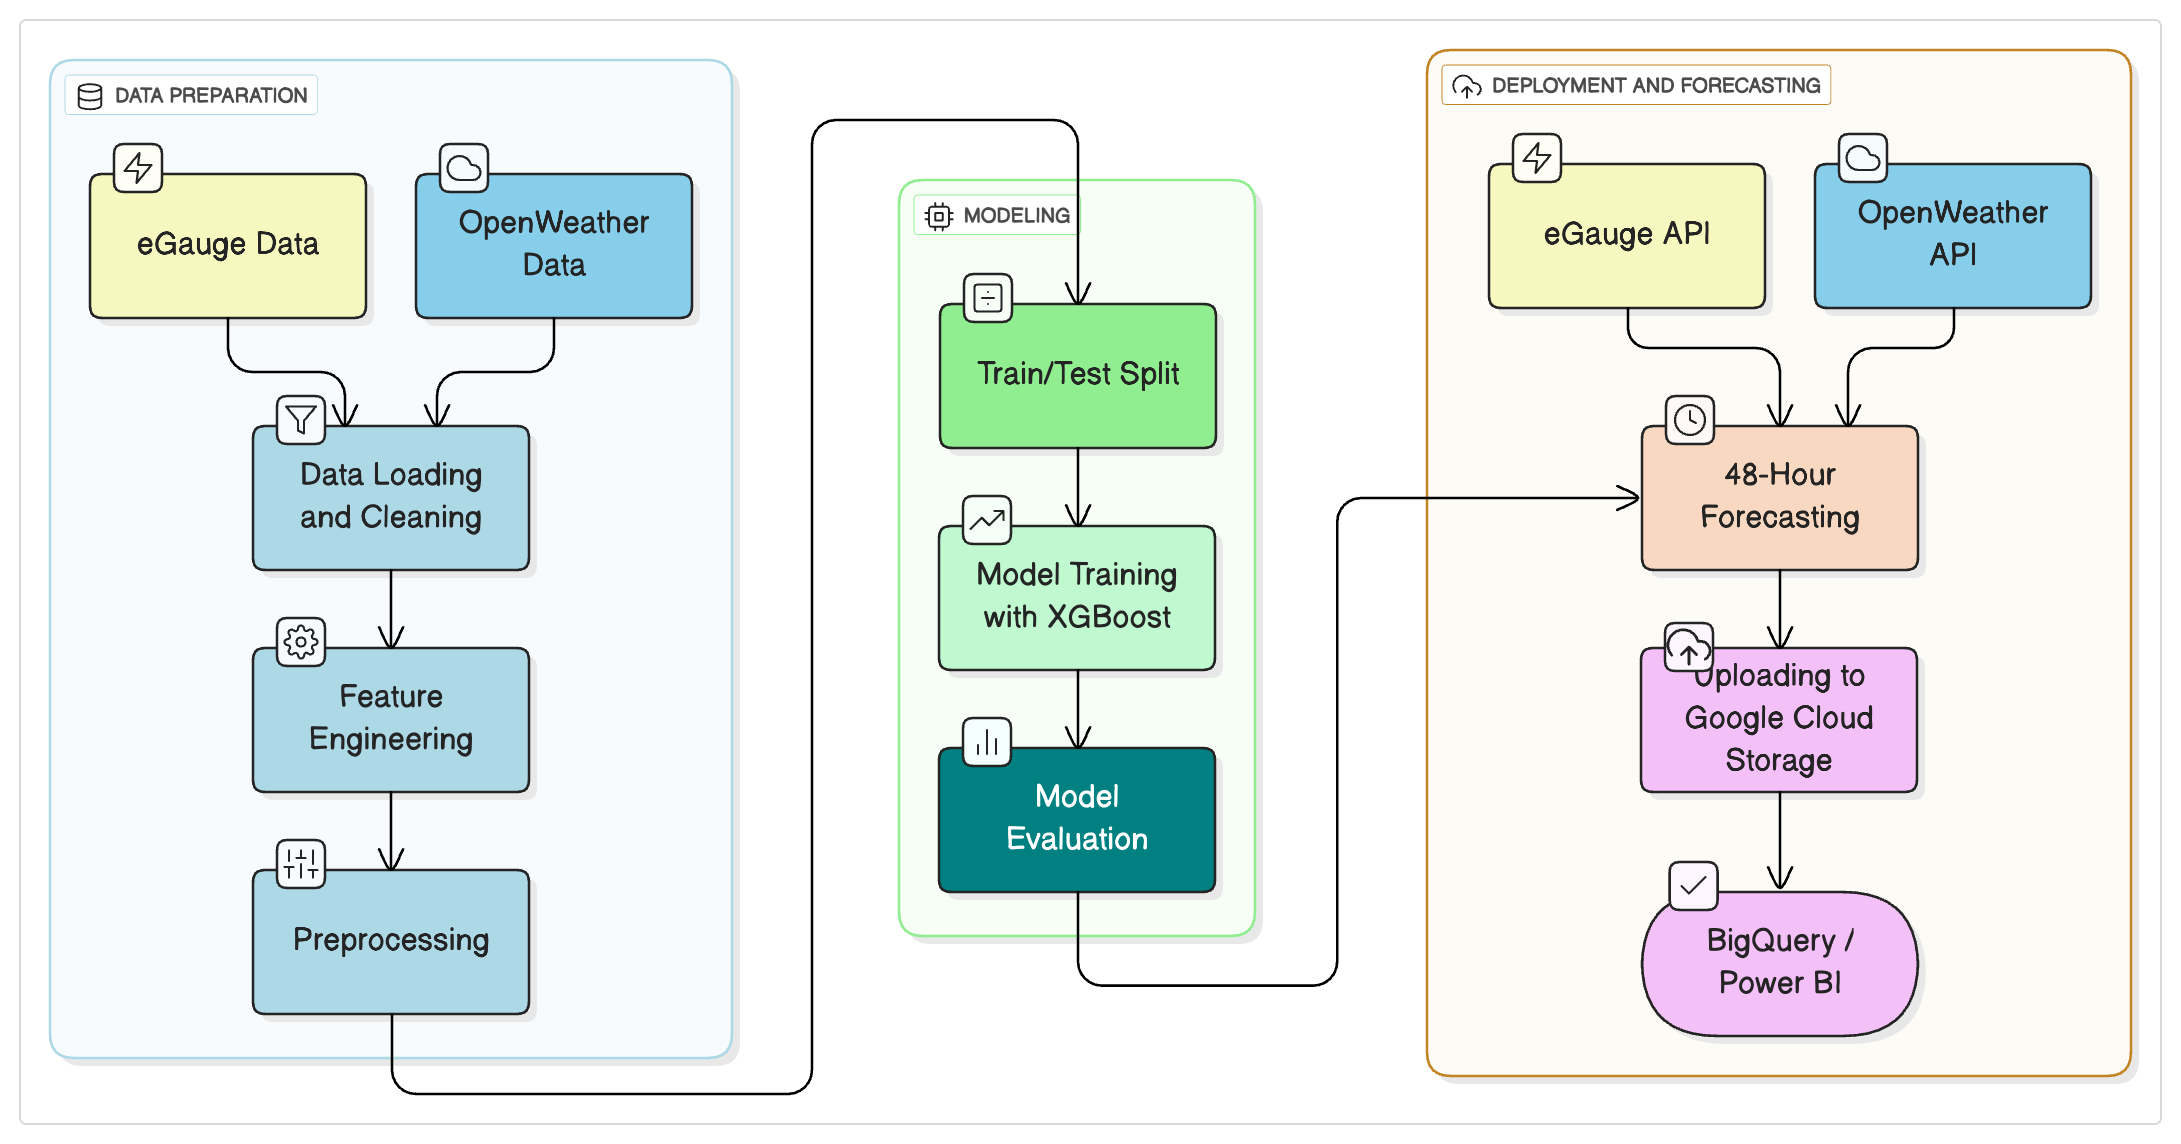

In [36]:
display(Image(filename="screenshots/block_diagram.png"))

### Loading and cleaning

The notebook starts by loading two primary datasets:

- Energy consumption data (residencial_2020_2025.csv)

- Weather data from OpenWeather (residencial_clima_2020_2025.json)

**Energy Consumption Data (eGauge)**

The energy data is collected using an eGauge monitoring device installed at a residential house in Los Sueños, Puntarenas, Costa Rica. The device has been actively recording consumption since 2019, capturing data in 15-minute intervals. These readings are exported and stored in a CSV file, which includes timestamps and energy usage in kilowatts (kW). This structured dataset serves as the foundation for modeling usage patterns over time.

**Weather Data (OpenWeather)**

To enhance the model with contextual information, we also obtained a historical weather dataset using the OpenWeather platform. The data corresponds to the same geographic location as the house (Los Sueños), using its latitude and longitude. Weather readings such as temperature, humidity, pressure, cloud cover, and wind conditions are aligned with the energy data through interpolation and merging.

The two datasets are merged on their timestamps using an as-of join, and missing weather values are forward-filled to maintain continuity in the time series.

We begin by loading the data and merging the datasets:

In [4]:
# Phase 1: Data Loading & Cleaning

print("Loading energy dataset...")
df_energy = load_energy_data(file_energy)
print("Energy data loaded:", df_energy.shape)

print("Loading historical weather dataset...")
df_weather = load_weather_data(file_weather)
print("Weather data loaded:", df_weather.shape)

print("Merging energy and weather data...")
df_merged = merge_energy_weather(df_energy, df_weather)
print("Merged data shape:", df_merged.shape)

# Quick inspection
print("\nPreview of merged dataset:")
df_merged.head()

Loading energy dataset...


/var/folders/7c/v4n21vyj2jqd7blz8jrb3y8w0000gn/T/ipykernel_34953/3736713002.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date & Time"] = pd.to_datetime(df["Date & Time"])


Energy data loaded: (189116, 2)
Loading historical weather dataset...
Weather data loaded: (47280, 9)
Merging energy and weather data...
Merged data shape: (189116, 10)

Preview of merged dataset:


/var/folders/7c/v4n21vyj2jqd7blz8jrb3y8w0000gn/T/ipykernel_34953/3736713002.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


Date & Time   Usage_kW   temp  feels_like  pressure  humidity  \
0 2020-01-01 00:00:00  28.229129  25.93       26.88      1010        88   
1 2020-01-01 00:15:00  27.482607  25.93       26.88      1010        88   
2 2020-01-01 00:30:00  26.969364  25.93       26.88      1010        88   
3 2020-01-01 00:45:00  28.034004  25.93       26.88      1010        88   
4 2020-01-01 01:00:00  34.043876  25.83       26.77      1012        88   

   dew_point  cloud_coverage  wind_speed  wind_deg  
0      23.79              98        1.98       154  
1      23.79              98        1.98       154  
2      23.79              98        1.98       154  
3      23.79              98        1.98       154  
4      23.69              99        1.78       144

## Phase 2: Feature Engineering

To enrich the dataset, several types of features are engineered:

- Temporal features: hour, minute, day of the week, and weekend indicator
  
- Lag features: consumption values at various past intervals (e.g., 1, 4, 12, 96 timesteps)

- Rolling statistics: moving averages and standard deviations over multiple time windows

- Normalization: the target variable Usage_kW is scaled to Usage_kW_norm using min-max scaling

This prepares the dataset for robust time-series modeling.

We also save the min and max values recorded for denormalization (plotting):


In [5]:
# Phase 2: Feature Engineering
df_features, usage_min, usage_max = engineer_features(df_merged)
df_features.head()

Date & Time   Usage_kW   temp  feels_like  pressure  humidity  \
0 2020-01-01 00:00:00  28.229129  25.93       26.88      1010        88   
1 2020-01-01 00:15:00  27.482607  25.93       26.88      1010        88   
2 2020-01-01 00:30:00  26.969364  25.93       26.88      1010        88   
3 2020-01-01 00:45:00  28.034004  25.93       26.88      1010        88   
4 2020-01-01 01:00:00  34.043876  25.83       26.77      1012        88   

   dew_point  cloud_coverage  wind_speed  wind_deg  ...  rolling_std_4  \
0      23.79              98        1.98       154  ...            NaN   
1      23.79              98        1.98       154  ...            NaN   
2      23.79              98        1.98       154  ...            NaN   
3      23.79              98        1.98       154  ...            NaN   
4      23.69              99        1.78       144  ...       0.568865   

   rolling_mean_12  rolling_std_12  rolling_mean_96  rolling_std_96  \
0              NaN             NaN              NaN             NaN   
1              NaN             NaN              NaN             NaN   
2              NaN             NaN              NaN             NaN   
3              NaN             NaN              NaN             NaN   
4              NaN             NaN              NaN             NaN   

   rolling_mean_192  rolling_std_192  rolling_mean_672  rolling_std_672  \
0               NaN              NaN               NaN              NaN   
1               NaN              NaN               NaN              NaN   
2               NaN              NaN               NaN              NaN   
3               NaN              NaN               NaN              NaN   
4               NaN              NaN               NaN              NaN   

   Usage_kW_norm  
0       0.664229  
1       0.654578  
2       0.647942  
3       0.661706  
4       0.739403  

[5 rows x 34 columns]

In [6]:
df_features.columns

Index(['Date & Time', 'Usage_kW', 'temp', 'feels_like', 'pressure', 'humidity',
       'dew_point', 'cloud_coverage', 'wind_speed', 'wind_deg', 'hour',
       'minute', 'dayofweek', 'is_weekend', 'hour_sin', 'hour_cos', 'is_night',
       'lag_1', 'lag_4', 'lag_12', 'lag_96', 'lag_192', 'lag_672',
       'rolling_mean_4', 'rolling_std_4', 'rolling_mean_12', 'rolling_std_12',
       'rolling_mean_96', 'rolling_std_96', 'rolling_mean_192',
       'rolling_std_192', 'rolling_mean_672', 'rolling_std_672',
       'Usage_kW_norm'],
      dtype='object')

The complete list and description of the used features for training is:

| Feature Name        | Description                                                           |
|---------------------|-----------------------------------------------------------------------|
| temp                | Air temperature (°C) from OpenWeather.                                |
| feels_like          | Perceived temperature considering wind and humidity.                  |
| pressure            | Atmospheric pressure (hPa).                                           |
| humidity            | Relative humidity (%).                                                |
| dew_point           | Dew point temperature (°C).                                           |
| cloud_coverage      | Cloud coverage percentage.                                            |
| wind_speed          | Wind speed (m/s).                                                     |
| wind_deg            | Wind direction (degrees).                                             |
| hour                | Hour of the day (0–23).                                               |
| hour_sin            | Cyclical sine encoding of the hour (captures time-of-day behavior).   |
| hour_cos            | Cyclical cosine encoding of the hour (captures time-of-day behavior). |
| is_night            | 1 if hour is between 10 PM and 6 AM, else 0.                          |
| minute              | Minute of the hour (0–59).                                            |
| dayofweek           | Day of the week (0=Monday, 6=Sunday).                                 |
| is_weekend          | 1 if day is Saturday or Sunday, else 0.                               |
| lag_1               | Consumption 1 step (15 min) before.                                   |
| lag_4               | Consumption 1 hour before.                                            |
| lag_12              | Consumption 3 hours before.                                           |
| lag_96              | Consumption 1 day before.                                             |
| lag_192             | Consumption 2 days before.                                            |
| lag_672             | Consumption 1 week before.                                            |
| rolling_mean_4      | Mean consumption over the last 1 hour.                                |
| rolling_mean_12     | Mean consumption over the last 3 hours.                               |
| rolling_mean_96     | Mean consumption over the last 1 day.                                 |
| rolling_mean_192    | Mean consumption over the last 2 days.                                |
| rolling_mean_672    | Mean consumption over the last 1 week.                                |
| rolling_std_4       | Standard deviation of consumption over the last 1 hour.               |
| rolling_std_12      | Standard deviation over the last 3 hours.                             |
| rolling_std_96      | Standard deviation over the last 1 day.                               |
| rolling_std_192     | Standard deviation over the last 2 days.                              |
| rolling_std_672     | Standard deviation over the last 1 week.                              |

## Phase 3: Preprocessing

The dataset is cleaned by dropping rows with missing values introduced by lag and rolling operations. The final matrix is split into:

- X: the feature matrix

- y: the normalized target variable

In [7]:
# Phase 3: Preprocessing
X, y, df_clean = preprocess_for_training(df_features)
df_clean.head()


Preprocessing complete
Clean shape: (188444, 34)
Feature matrix shape: (188444, 31)
Target vector shape: (188444,)


Date & Time  Usage_kW   temp  feels_like  pressure  humidity  \
672 2020-01-08 00:00:00  7.144483  27.62       30.42      1010        74   
673 2020-01-08 00:15:00  6.822520  27.62       30.42      1010        74   
674 2020-01-08 00:30:00  6.591524  27.62       30.42      1010        74   
675 2020-01-08 00:45:00  6.419356  27.62       30.42      1010        74   
676 2020-01-08 01:00:00  6.666888  27.54       29.91      1011        71   

     dew_point  cloud_coverage  wind_speed  wind_deg  ...  rolling_std_4  \
672      22.57               1        0.55       172  ...       0.674565   
673      22.57               1        0.55       172  ...       0.783021   
674      22.57               1        0.55       172  ...       0.967553   
675      22.57               1        0.55       172  ...       0.750559   
676      21.81               1        1.34        28  ...       0.313685   

     rolling_mean_12  rolling_std_12  rolling_mean_96  rolling_std_96  \
672         9.099108        1.188448         9.116000        2.461012   
673         8.762996        1.115198         9.090280        2.468647   
674         8.475417        1.135055         9.067502        2.479467   
675         8.192173        1.146648         9.049654        2.491153   
676         7.873075        1.051200         9.024120        2.505529   

     rolling_mean_192  rolling_std_192  rolling_mean_672  rolling_std_672  \
672         12.293816         4.300600         19.092311         6.488283   
673         12.227913         4.281915         19.060935         6.495011   
674         12.162846         4.268551         19.030191         6.503978   
675         12.090317         4.244093         18.999867         6.514404   
676         12.021322         4.227932         18.967702         6.523087   

     Usage_kW_norm  
672       0.391641  
673       0.387478  
674       0.384492  
675       0.382266  
676       0.385466  

[5 rows x 34 columns]

## Phase 4: Train/Test Split

To simulate real-world forecasting conditions, we perform a custom time-based split of the dataset:

- Training period: January 1, 2020 → December 31, 2023

- Testing period: January 1, 2024 → December 31, 2024

This chronological split ensures that the model is trained exclusively on past data and evaluated on future data, just like it would be in a production environment. By preserving time order, we avoid data leakage, where the model could accidentally "peek" at future information during training.

This setup also allows us to:

- Validate how well the model generalizes to new, unseen patterns in 2024.

- Measure performance realistically for the 48-hour forecasting task ahead.

In [8]:
# Phase 4: Train/Test Split
train_range = ("2020-01-01", "2024-01-01") # YYYY-MM-DD format
test_range = ("2024-01-01", "2025-01-01") # YYYY-MM-DD format

X_train, y_train, X_test, y_test, df_train, df_test = split_train_test(df_clean, train_range, test_range)


Custom train/test split complete
Train shape: (139584, 31)
Test shape: (35136, 31)
Train period: 2020-01-08 00:00:00 to 2023-12-31 23:45:00
Test period: 2024-01-01 00:00:00 to 2024-12-31 23:45:00


In [9]:
df_train.head()

Date & Time  Usage_kW   temp  feels_like  pressure  humidity  \
672 2020-01-08 00:00:00  7.144483  27.62       30.42      1010        74   
673 2020-01-08 00:15:00  6.822520  27.62       30.42      1010        74   
674 2020-01-08 00:30:00  6.591524  27.62       30.42      1010        74   
675 2020-01-08 00:45:00  6.419356  27.62       30.42      1010        74   
676 2020-01-08 01:00:00  6.666888  27.54       29.91      1011        71   

     dew_point  cloud_coverage  wind_speed  wind_deg  ...  rolling_std_4  \
672      22.57               1        0.55       172  ...       0.674565   
673      22.57               1        0.55       172  ...       0.783021   
674      22.57               1        0.55       172  ...       0.967553   
675      22.57               1        0.55       172  ...       0.750559   
676      21.81               1        1.34        28  ...       0.313685   

     rolling_mean_12  rolling_std_12  rolling_mean_96  rolling_std_96  \
672         9.099108        1.188448         9.116000        2.461012   
673         8.762996        1.115198         9.090280        2.468647   
674         8.475417        1.135055         9.067502        2.479467   
675         8.192173        1.146648         9.049654        2.491153   
676         7.873075        1.051200         9.024120        2.505529   

     rolling_mean_192  rolling_std_192  rolling_mean_672  rolling_std_672  \
672         12.293816         4.300600         19.092311         6.488283   
673         12.227913         4.281915         19.060935         6.495011   
674         12.162846         4.268551         19.030191         6.503978   
675         12.090317         4.244093         18.999867         6.514404   
676         12.021322         4.227932         18.967702         6.523087   

     Usage_kW_norm  
672       0.391641  
673       0.387478  
674       0.384492  
675       0.382266  
676       0.385466  

[5 rows x 34 columns]

In [10]:
df_test.head()

Date & Time   Usage_kW   temp  feels_like  pressure  humidity  \
140256 2024-01-01 00:00:00  13.544433  27.11       30.29      1013        83   
140257 2024-01-01 00:15:00  21.250376  27.11       30.29      1013        83   
140258 2024-01-01 00:30:00  19.895969  27.11       30.29      1013        83   
140259 2024-01-01 00:45:00  20.177709  27.11       30.29      1013        83   
140260 2024-01-01 01:00:00  17.171741  26.94       29.79      1013        82   

        dew_point  cloud_coverage  wind_speed  wind_deg  ...  rolling_std_4  \
140256      23.97              90        2.49       175  ...       5.063139   
140257      23.97              90        2.49       175  ...       4.074550   
140258      23.97              90        2.49       175  ...       4.500504   
140259      23.97              90        2.49       175  ...       4.539185   
140260      23.60              77        1.25       173  ...       3.497479   

        rolling_mean_12  rolling_std_12  rolling_mean_96  rolling_std_96  \
140256        19.210500        3.497842        17.978711        3.168617   
140257        18.552979        3.772547        17.946527        3.197973   
140258        18.563063        3.780213        18.013983        3.198660   
140259        18.430081        3.694928        18.086533        3.160924   
140260        18.414974        3.686686        18.159397        3.127136   

        rolling_mean_192  rolling_std_192  rolling_mean_672  rolling_std_672  \
140256         18.469267         3.454139         18.894914         7.403916   
140257         18.434781         3.470129         18.902266         7.396129   
140258         18.435133         3.470412         18.921159         7.385866   
140259         18.438913         3.471612         18.938586         7.374303   
140260         18.443858         3.473418         18.955137         7.364564   

        Usage_kW_norm  
140256       0.474381  
140257       0.574006  
140258       0.556496  
140259       0.560138  
140260       0.521276  

[5 rows x 34 columns]

## Phase 5: Model training with XGBoost

In this phase, we train an XGBoost Regressor (XGBRegressor) to predict normalized energy consumption (*Usage_kW_norm*). The model is trained using historical data enriched with temporal and weather-based features.

**Why XGBoost?**

XGBoost (Extreme Gradient Boosting) is a high-performance, scalable implementation of gradient boosting. It's widely used in time series forecasting tasks due to the following key characteristics that make it a great option for this project:

- No need to scale everything: Since XGBoost is based on decision trees, it doesn’t care whether a feature is measured in degrees, percentages, or kilowatts. That makes life easier when mixing things like temperature, time-of-day, and energy usage in the same model.

- Tolerates missing values: In real-world scenarios, weather APIs sometimes miss a reading or two, or sensor data can be delayed. XGBoost can handle these gaps intelligently without needing us to fill them manually.

- Built-in protection against overfitting: The algorithm includes tools like regularization that act like a safety net, especially helpful when you're working with a lot of training data (like full years in our case).

- Great for this kind of dataset: We’re working with tabular, time-indexed data—something XGBoost is known to perform really well on, especially when the dataset has a mix of continuous and categorical-like features (like weekend indicators or rolling averages).

- You can understand its decisions: One of the nice things about XGBoost is that it can show you which features it relied on the most. That helps us validate whether the model is behaving as expected—for example, confirming that time-of-day or weather patterns really are influencing the forecast.

An XGBRegressor model is trained to forecast normalized energy consumption using a robust and time-aware strategy:

- **TimeSeriesSplit** is used for cross-validation, ensuring that validation data always comes from the future relative to the training set—this better reflects real forecasting conditions and helps prevent data leakage.

- **GridSearchCV** is applied to search for the best combination of hyperparameters, including tree depth, learning rate, and number of estimators.

- **Regularization and conservative model depth** (e.g. max_depth=3) are built-in to XGBoost and help reduce the risk of overfitting, especially when the training set spans multiple years.

- **Early stopping and learning curves** are used to monitor and halt training before the model begins to overfit.

- **Feature importance plots** help us understand which inputs (lags, weather, time-of-day) drive predictions, adding interpretability to the model.

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best model saved as 'xgboost_best_model.joblib'


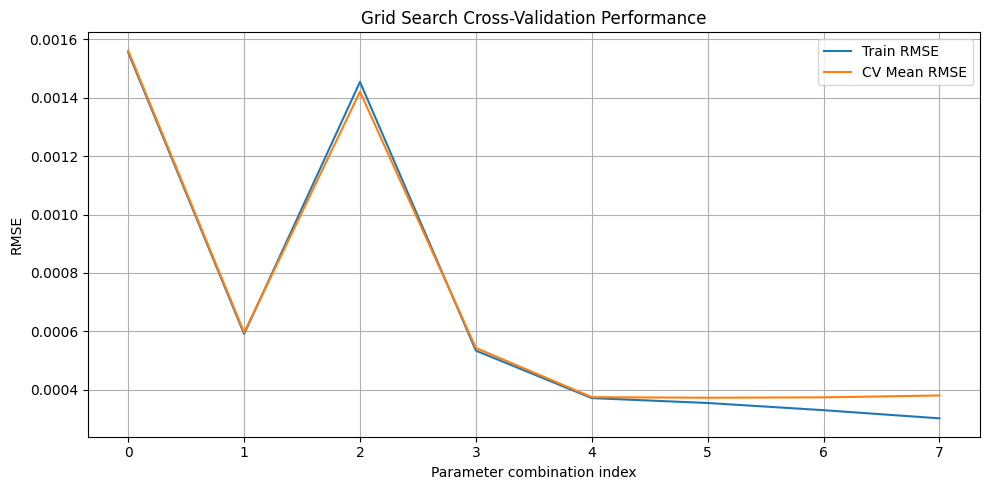

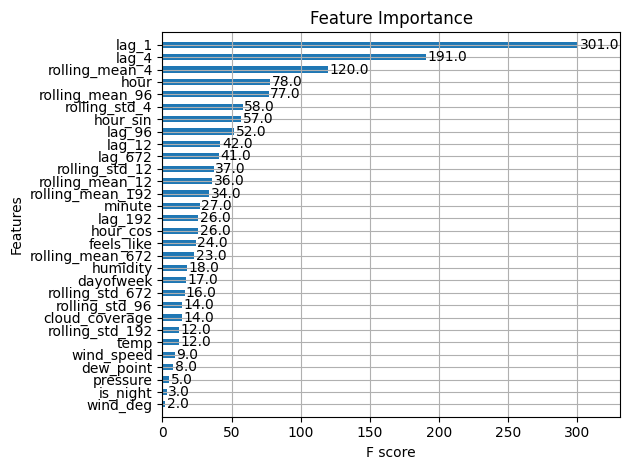

In [11]:
# Phase 5: XGBoost training
model = train_xgboost_model(X_train, y_train, usage_min, usage_max)

The *Grid Search Cross Validation Performance* plot shows the performance of different XGBoost hyperparameter combinations during grid search cross-validation, using Root Mean Squared Error (RMSE) as the evaluation metric. This graph is used to compare model performance across different parameter sets, helping us choose the one that generalizes best—not just the one that fits the training data the closest. The best model was found at index 1, with the lowest validation RMSE and a minimal gap between training and validation error.

The *Feature Importance* plot shows the frequency of the different features that the model used during training. This gives us insight into which features most strongly influenced the predictions.

**Top features:**

- *lag_1* — by far the most important feature: This is the energy consumption value from 15 minutes before. The model heavily relies on the most recent observation to predict the next one.

- *rolling_mean_4*, *lag_4*, and *hour* — These represent recent consumption patterns (1 hour average, 1 hour lag) and time of day, which are strongly correlated with daily usage cycles.

- *hour_sin* — Cyclic time encoding that helps the model better capture repetitive daily patterns.

- *rolling_std_4*, *lag_96* — Useful for adding variability awareness and daily memory.

**Lower importance features:**

- *hour_cos*, *feels_like*, and *humidity* — While informative, these features play a secondary role in short-term prediction.

- *is_night* — The binary indicator for nighttime hours showed limited usage, likely because other time and lag features already capture similar behavior.

- *rolling_mean_672*, *wind_deg*, and *pressure* — These features had very low f-scores, indicating that long-term patterns or specific weather details like wind direction have minimal influence on short-term consumption forecasts in this dataset.

The best trained model was also saved locally as *xgboost_best_model.joblib*

## Phase 6: Model evaluation

The test dataset is evaluated month-by-month against the test set. For each month:

- Predictions are denormalized back to kW

- MAE and RMSE are calculated on denormalized values (*Usage_kW* scale)

- Line plots show predicted vs. actual values for visual inspection

This helps identify seasonal variations and performance stability.

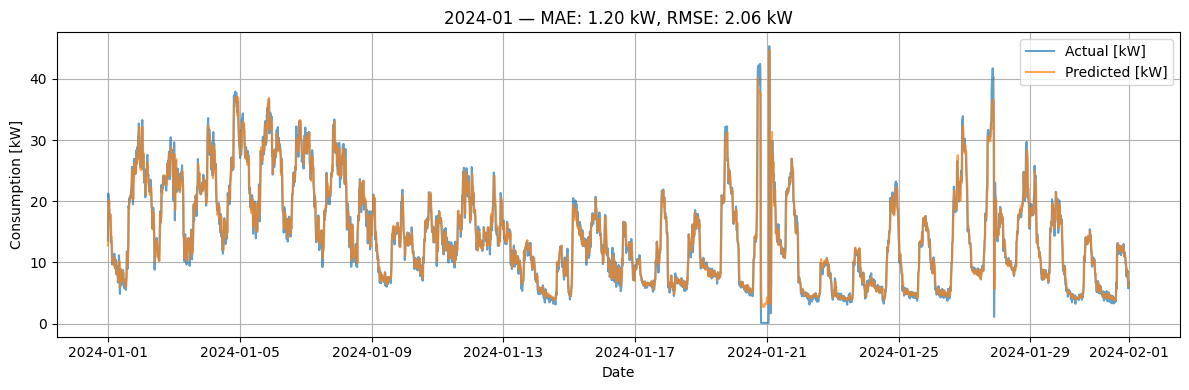

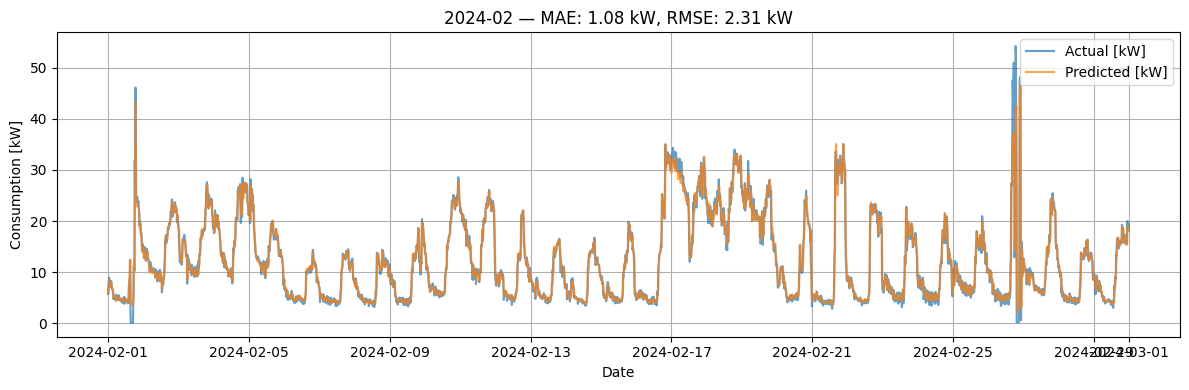

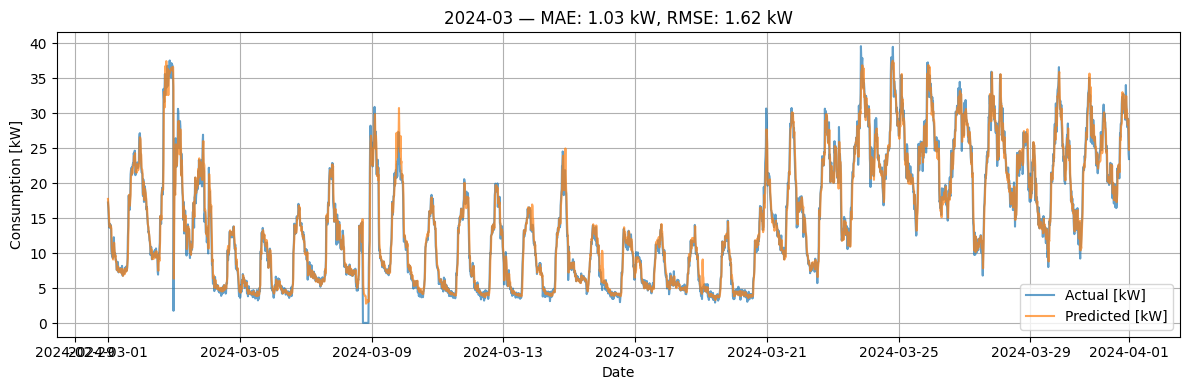

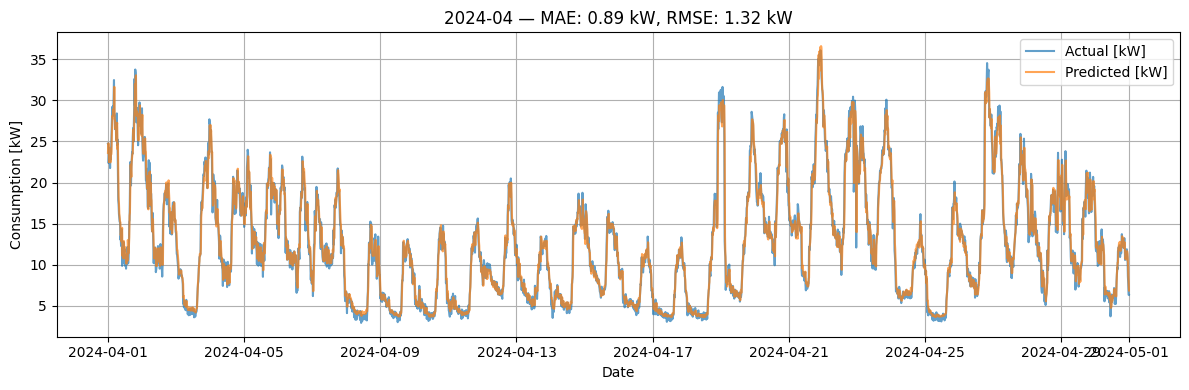

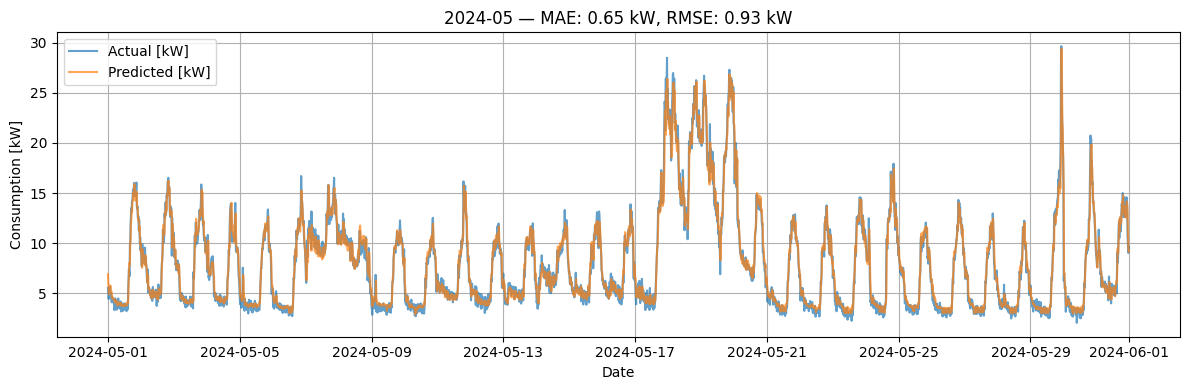

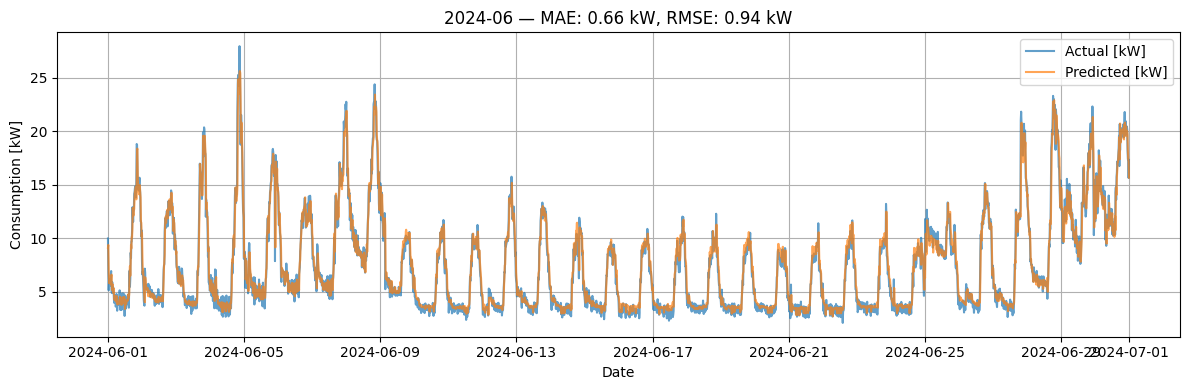

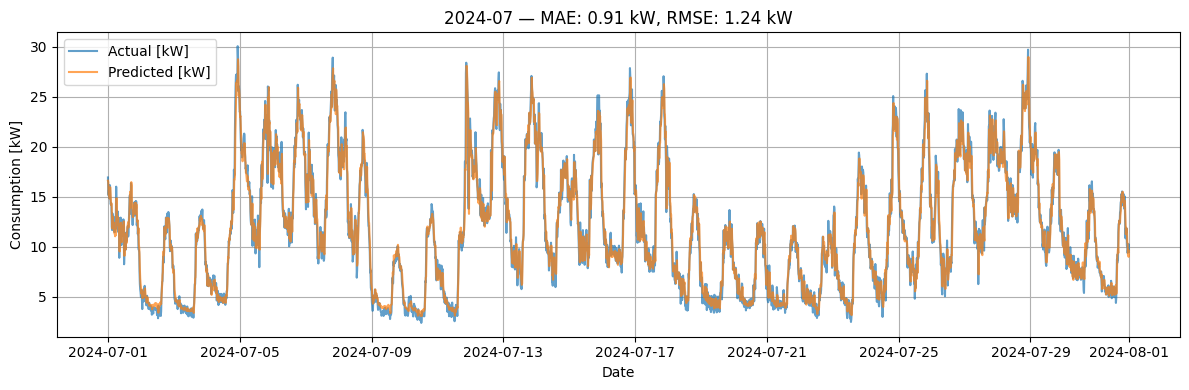

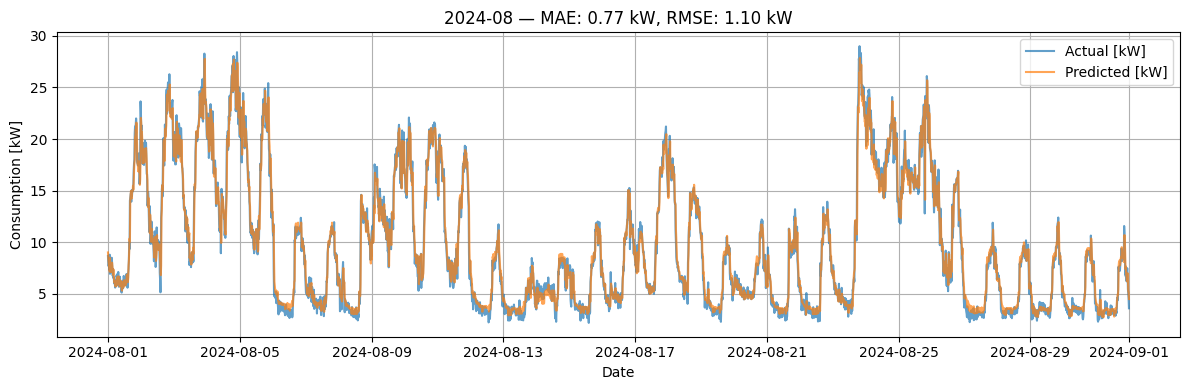

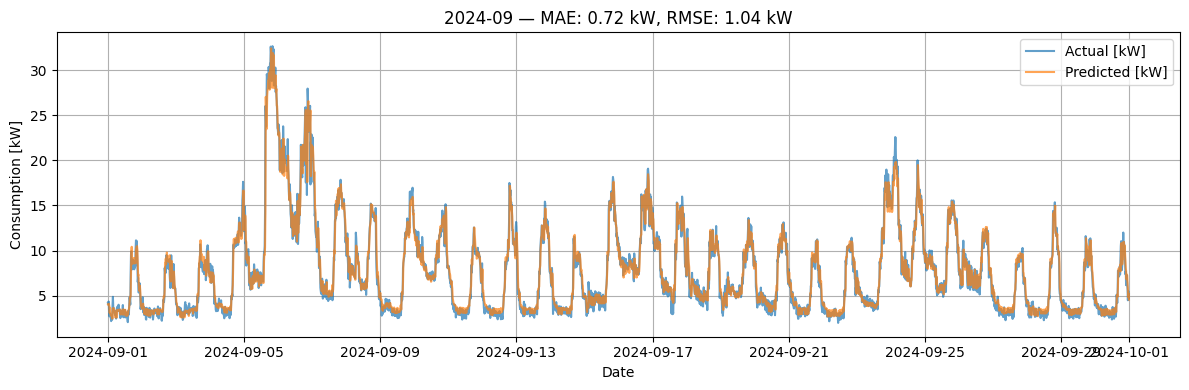

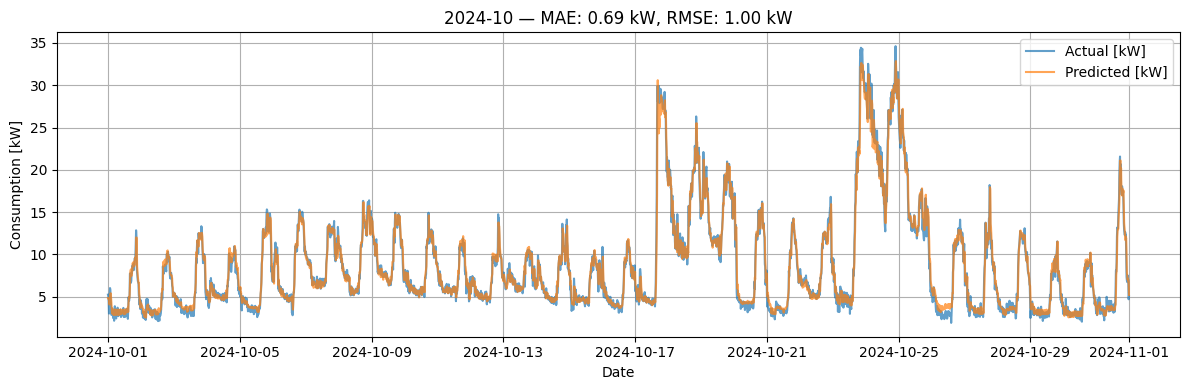

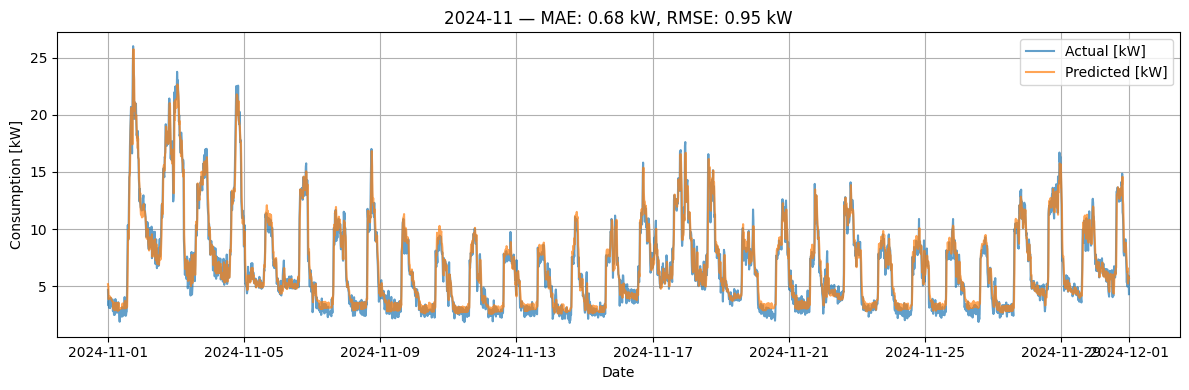

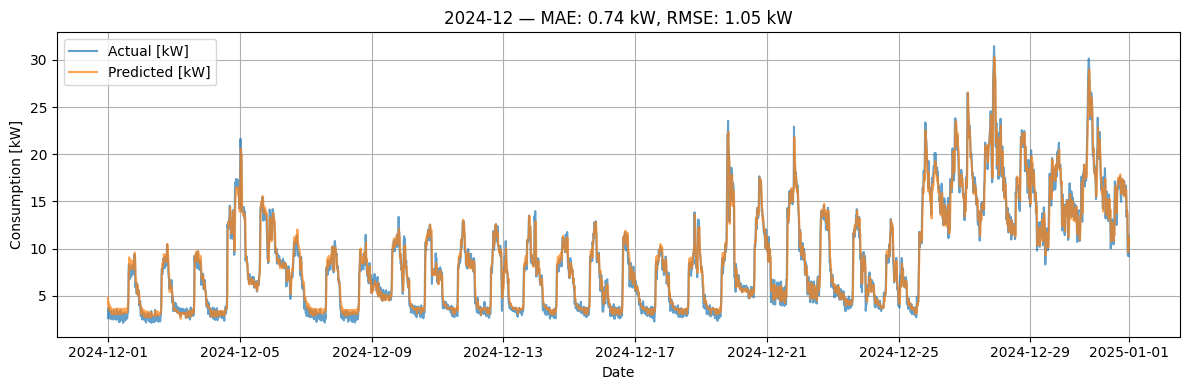


Test Set Evaluation Summary:
Average MAE: 0.83 kW
Maximum MAE: 1.20 kW
Average RMSE: 1.30 kW
Maximum RMSE: 2.31 kW


In [12]:
# Phase 6: Evaluate model on test set
evaluate_on_test_months(model, X_test, y_test, df_test, usage_min, usage_max)

Results show a very good fit from the model to the variable short-term patterns.

## Phase 7: 48-hour forecasting

In this phase, we generate a 48-hour ahead energy consumption forecast using the trained XGBoost model. The forecast is fully automated and simulates how the model would perform in a real-world deployment, updating with live data and using only future-facing inputs.

**Fill missing consumption data with eGauge API**

Before we forecast, we make sure the energy dataset is complete:

- The model requires a continuous stream of past data to compute lag and rolling features.

- To do this, we query the eGauge API to retrieve any missing 15-minute intervals between the last date in the historical dataset and the current time (now).

This step ensures we are always starting the forecast from the most up-to-date state of the house in Los Sueños, Puntarenas, Costa Rica.

**Get and prepare the weather forecast**

We then fetch the 48-hour hourly weather forecast using the OpenWeather API, based on the latitude and longitude of the house.

- The raw weather data includes temperature, humidity, and cloud coverage.

- Any missing or incomplete weather fields are filled using historical hourly averages, grouped by (month, hour) combinations from the historical dataset.

This makes the weather input reliable even if OpenWeather returns partial data.

**Run Autoregressive Forecast Loop**

To simulate how future predictions unfold step-by-step:

- We initialize a rolling window with the latest consumption history.

- For each 15-minute step into the future (192 steps total), we:

    - Compute features like *lag_1*, *rolling_mean_4*, *hour*, *is_weekend*, etc.

    - Attach the weather data for that specific timestamp.

    - Use the model to predict the next value.

    - Feed that predicted value back into the rolling window, so it becomes part of the input for the next prediction.

This autoregressive forecasting approach mimics a production system where the model must rely on its own past outputs.

**Visualize the forecast**

To make the forecast easy to interpret:

- We plot the last 5 days of real consumption data.

- Then, we add the next 2 days (48 hours) of predicted values.

- A vertical red line marks the transition from historical data to future forecast.

This visualization helps validate that the forecast aligns naturally with recent consumption trends and responds to patterns like daily cycles.

In [13]:
# Phase 7: Predict 48h ahead

# OpenWeather API
api_key = "55969303f218ff7ae828f655fcd870f4"
lat = 9.660577
lon = -84.659828

# eGauge API
URI = "https://egauge50670.egaug.es"
USR = "admin"
PWD = "default"
dev = webapi.device.Device(URI, webapi.JWTAuth(USR, PWD))

# Timezone-aware current time
now = datetime.now(pytz.timezone("America/Costa_Rica"))
print(f"Actual time in Costa Rica: {now}")

# Fill consumption gaps with latest values
df_energy = fill_missing_consumption_from_egauge(df_energy, dev)

# Call the API and convert hourly forecast into a DataFrame
weather_data = get_weather_forecast(lat=lat, lon=lon, api_key=api_key)
df_weather_forecast = preparar_clima_openweather_hourly(weather_data["hourly"])

# Define weather features used in the model
forecast_features = ["temp", "humidity", "clouds"] + [col for col in df_weather_forecast.columns if col.startswith("weather_")]
weather_features = [f for f in forecast_features if f in df_weather.columns]

# Fill missing values in forecast using historical weather
df_weather_48h = fill_missing_weather(df_weather_forecast, df_weather, weather_features)
df_weather_48h = fill_weather_gap_until_now(df_weather, df_weather_48h, weather_features)

# Split filled forecast into:
#    - df_weather_backfill: real values from forecast (before now)
#    - df_weather_predicted: future values (true forecast)
df_weather_backfill = df_weather_48h[df_weather_48h.index < now].copy()
df_weather_predicted = df_weather_48h[df_weather_48h.index >= now].copy()

df_weather_predicted.index.name = "Date & Time"
df_weather_predicted = df_weather_predicted.reset_index()

# Merge backfill into historical weather to create updated real data
df_weather = append_backfill_to_weather(df_weather, df_weather_backfill)

# Get most recent consumption data to start the forecast
df_last_known = preparar_df_last_known(df_energy)

# Predict 48h ahead
#df_48h = predict_next_48h(model, df_last_known, usage_min, usage_max, df_weather_48h)
df_48h = predict_next_48h(model, df_last_known, usage_min, usage_max, df_weather_predicted)
df_48h["Date & Time"] = pd.to_datetime(df_48h["Date & Time"], utc=True)

Actual time in Costa Rica: 2025-05-29 05:08:22.249631-06:00
Filling 15-min blocks from 2025-05-24 00:00:00-06:00 to 2025-05-29 05:00:00-06:00
Appended 500 rows — from 2025-05-24 00:15:00-06:00 to 2025-05-29 05:00:00-06:00
Step 1: Ensuring datetime index for historical weather data...
   ➤ df_hist shape: (47280, 8)
   ➤ Historical weather range: 2020-01-01 00:00:00 to 2025-05-23 23:00:00
Step 2: Ensuring datetime index for forecast weather data...
   ➤ df_forecast shape before fill: (48, 5)
   ➤ Forecast weather range: 2025-05-29 11:00:00 to 2025-05-31 10:00:00
All 2 expected weather features available for filling.
Reindexing forecast from 2025-05-29 11:00:00 to 2025-05-31 10:00:00 (48 timestamps)
   ➤ df shape after reindex: (48, 7)
Filling 0 missing values for 'temp'...
Filling 0 missing values for 'humidity'...
Weather forecast filling complete.
   ➤ Final df shape: (48, 7)
Attempt 1: Buffer 1440 minutes — rows: 96
Attempt 2: Buffer 2880 minutes — rows: 192
Attempt 3: Buffer 5760 min

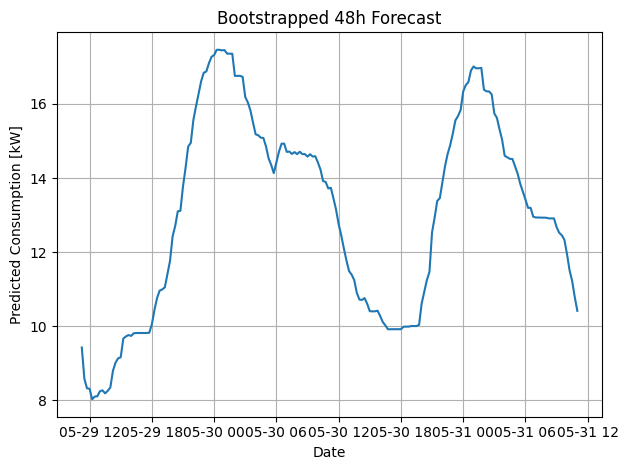

In [14]:
plt.plot(df_48h["Date & Time"], df_48h["Usage_kW"])
plt.title("Bootstrapped 48h Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Consumption [kW]")
plt.grid()
plt.tight_layout()
plt.show()

Forecast plot saved as: forecasts/forecast_plot_2025-05-29_05-36-22.png


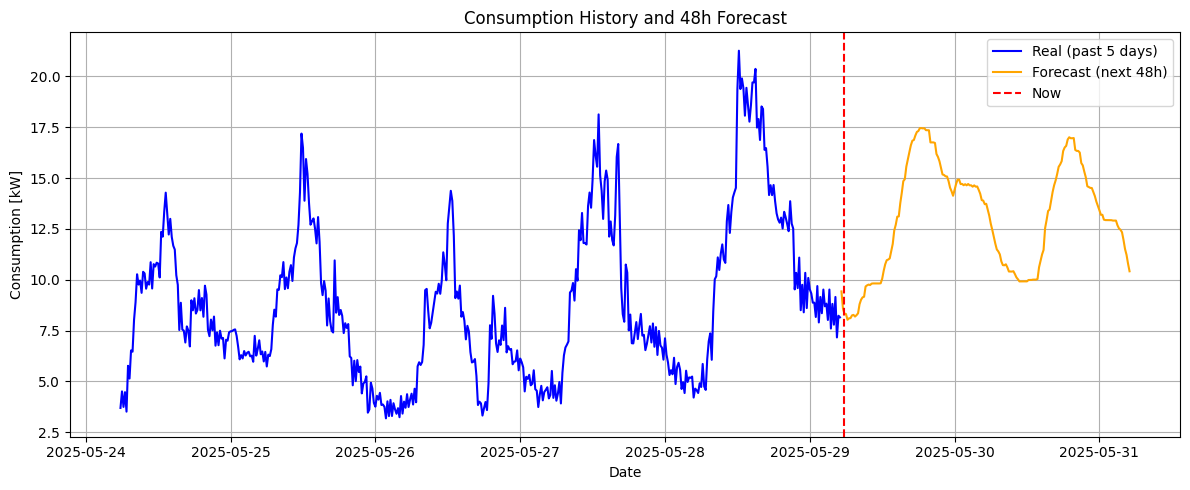

In [26]:
# Plot last 5 days and future 48 hours
plot_week_with_forecast(df_energy, df_48h)

To compare these results against the real consumption, we waited for 48 hours to obtain the actual data from the device. It is amazing how close the model forecasts the general pattern and min/max values:

*NOTE: See appendix notebook called "48h_comparison.ipynb for more details*

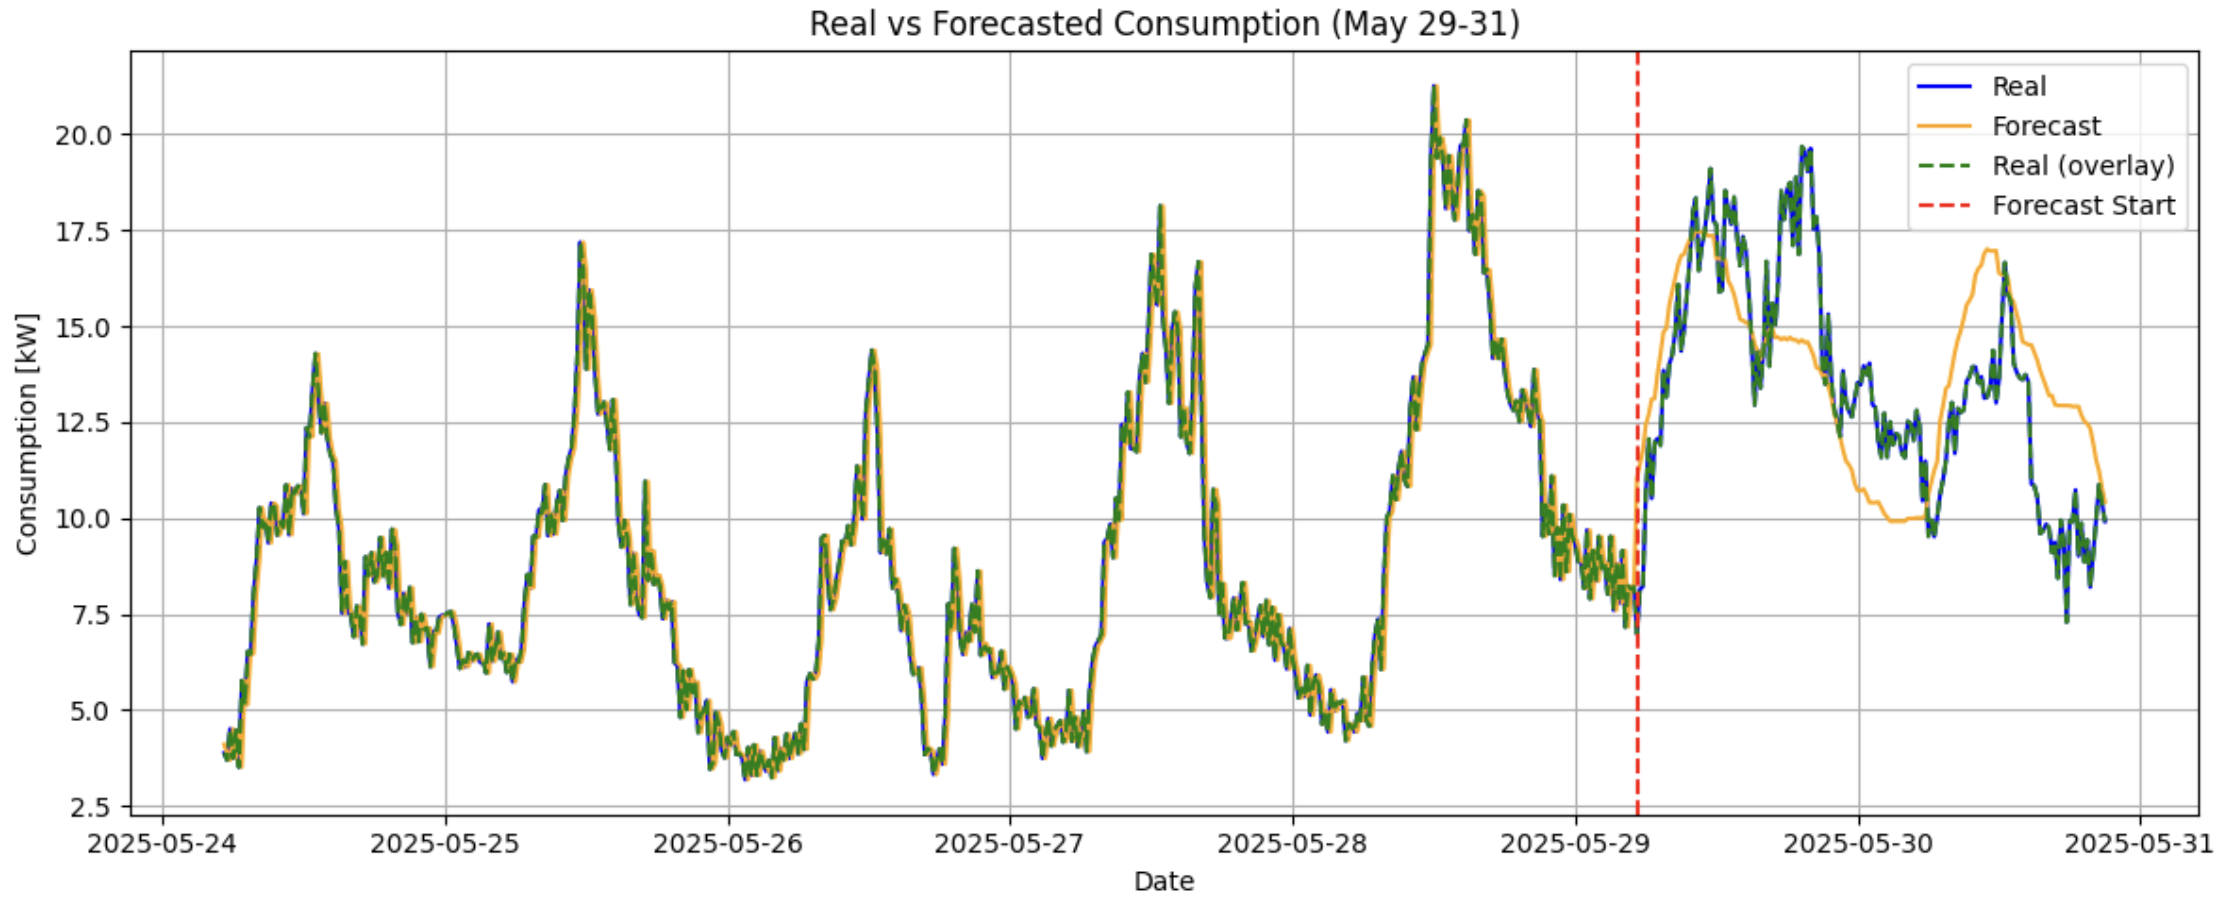

In [32]:
display(Image(filename="screenshots/48h_later.png"))

## Phase 8: Uploading to Google Cloud Storage (GCS)

We use Google Cloud Storage (GCS) as the centralized repository for both historical and forecasted energy and weather datasets. Data is organized in a query-friendly and time-partitioned structure that supports both real-time dashboards and retraining workflows.

**Storage structure**

Historical data (real, observed measurements) is uploaded as daily-partitioned Parquet files, enabling efficient date-based access and long-term archival.

Forecast data is stored in the same format and structure, but rows are clearly marked with a *"type": "predicted"* column. This allows consumers of the dataset to filter easily between actual and forecasted records.

**Smart merging logic**

To ensure consistency and avoid duplication:

- A single unified Parquet file is maintained in GCS, combining both historical and forecasted records.

- When new forecasts are generated, the logic:

    - Loads the existing merged file (if it exists),

    - Preserves all rows labeled as *"type": "real"*, and

    - Replaces only the *"type": "predicted"* rows that match the same timestamps.

- This ensures that each update includes the most recent predictions while keeping all historical data intact and version-safe.

- This guarantees that:

    - Real data is never overwritten

    - Forecasts can be continuously updated as models improve

    - Data remains clean and version-consistent

**Local CSV backup**

For inspection, auditing, or offline usage:

- A local CSV file containing the full merged dataset is saved with a timestamped filename (e.g., *voltix_forecast_YYYY-MM-DD_HH-MM-SS.csv*).

- This backup contains both historical and forecasted values, making it easy to review predictions and understand context.

By maintaining both version control and data integrity, this workflow supports real-world, production-grade forecasting at scale.

In [16]:
# GCS API
BUCKET_PATH = "gs://egauge-data/datos"
GCS_KEY_PATH = "data/gcs_key.json"

# Save Forecast CSV locally
local_path = "forecasts/weather_forecast_48h.csv"

# Load credentials
with open(GCS_KEY_PATH) as f:
    credentials = json.load(f)

In [34]:
# Upload integrated usage+weather real+predicted file to GCS and locally
df_unified = upload_merged_dataset_to_gcs_parquet(
    df_energy=df_energy,
    df_weather=df_weather,
    df_48h=df_48h,
    df_weather_48h=df_weather_predicted,
    bucket_path=BUCKET_PATH,
    credentials=credentials
)

/var/folders/7c/v4n21vyj2jqd7blz8jrb3y8w0000gn/T/ipykernel_34953/290799200.py:944: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_weather_interp[non_numeric_cols] = df_weather_interp[non_numeric_cols].ffill().bfill()
/var/folders/7c/v4n21vyj2jqd7blz8jrb3y8w0000gn/T/ipykernel_34953/290799200.py:944: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_weather_interp[non_numeric_cols] = df_weather_interp[non_numeric_cols].ffill().bfill()


Local CSV saved: forecasts/voltix_forecast_2025-05-31_14-06-29.csv
Unified Parquet uploaded to GCS: gs://egauge-data/datos/unified/merged_data.parquet


In [35]:
df_unified

Date & Time   Usage_kW    temp  feels_like  pressure  humidity  \
0      2020-01-01 00:00:00  28.229129  25.620     26.5100    1011.0     87.00   
1      2020-01-01 00:15:00  27.482607  25.600     26.4875    1011.0     87.00   
2      2020-01-01 00:30:00  26.969364  25.580     26.4650    1011.0     87.00   
3      2020-01-01 00:45:00  28.034004  25.560     26.4425    1011.0     87.00   
4      2020-01-01 01:00:00  34.043876  25.540     26.4200    1011.0     87.00   
...                    ...        ...     ...         ...       ...       ...   
189783 2025-05-31 04:00:00  11.957848  27.650         NaN       NaN     80.00   
189784 2025-05-31 04:15:00  11.514065  27.545         NaN       NaN     80.25   
189785 2025-05-31 04:30:00  11.226154  27.440         NaN       NaN     80.50   
189786 2025-05-31 04:45:00  10.791325  27.335         NaN       NaN     80.75   
189787 2025-05-31 05:00:00  10.417629  27.230         NaN       NaN     81.00   

        dew_point  cloud_coverage  wind_speed  wind_deg  clouds  \
0           23.29            90.0       0.980     46.00     NaN   
1           23.27            88.0       0.945     51.75     NaN   
2           23.25            86.0       0.910     57.50     NaN   
3           23.23            84.0       0.875     63.25     NaN   
4           23.21            82.0       0.840     69.00     NaN   
...           ...             ...         ...       ...     ...   
189783        NaN             NaN         NaN       NaN   100.0   
189784        NaN             NaN         NaN       NaN   100.0   
189785        NaN             NaN         NaN       NaN   100.0   
189786        NaN             NaN         NaN       NaN   100.0   
189787        NaN             NaN         NaN       NaN   100.0   

       weather_Clouds weather_Rain       type  
0                 NaN          NaN       real  
1                 NaN          NaN       real  
2                 NaN          NaN       real  
3                 NaN          NaN       real  
4                 NaN          NaN       real  
...               ...          ...        ...  
189783            0.0          1.0  predicted  
189784            0.0          1.0  predicted  
189785            0.0          1.0  predicted  
189786            0.0          1.0  predicted  
189787            0.0          1.0  predicted  

[189788 rows x 14 columns]

We can confirm that the bucket was updated in GCS:

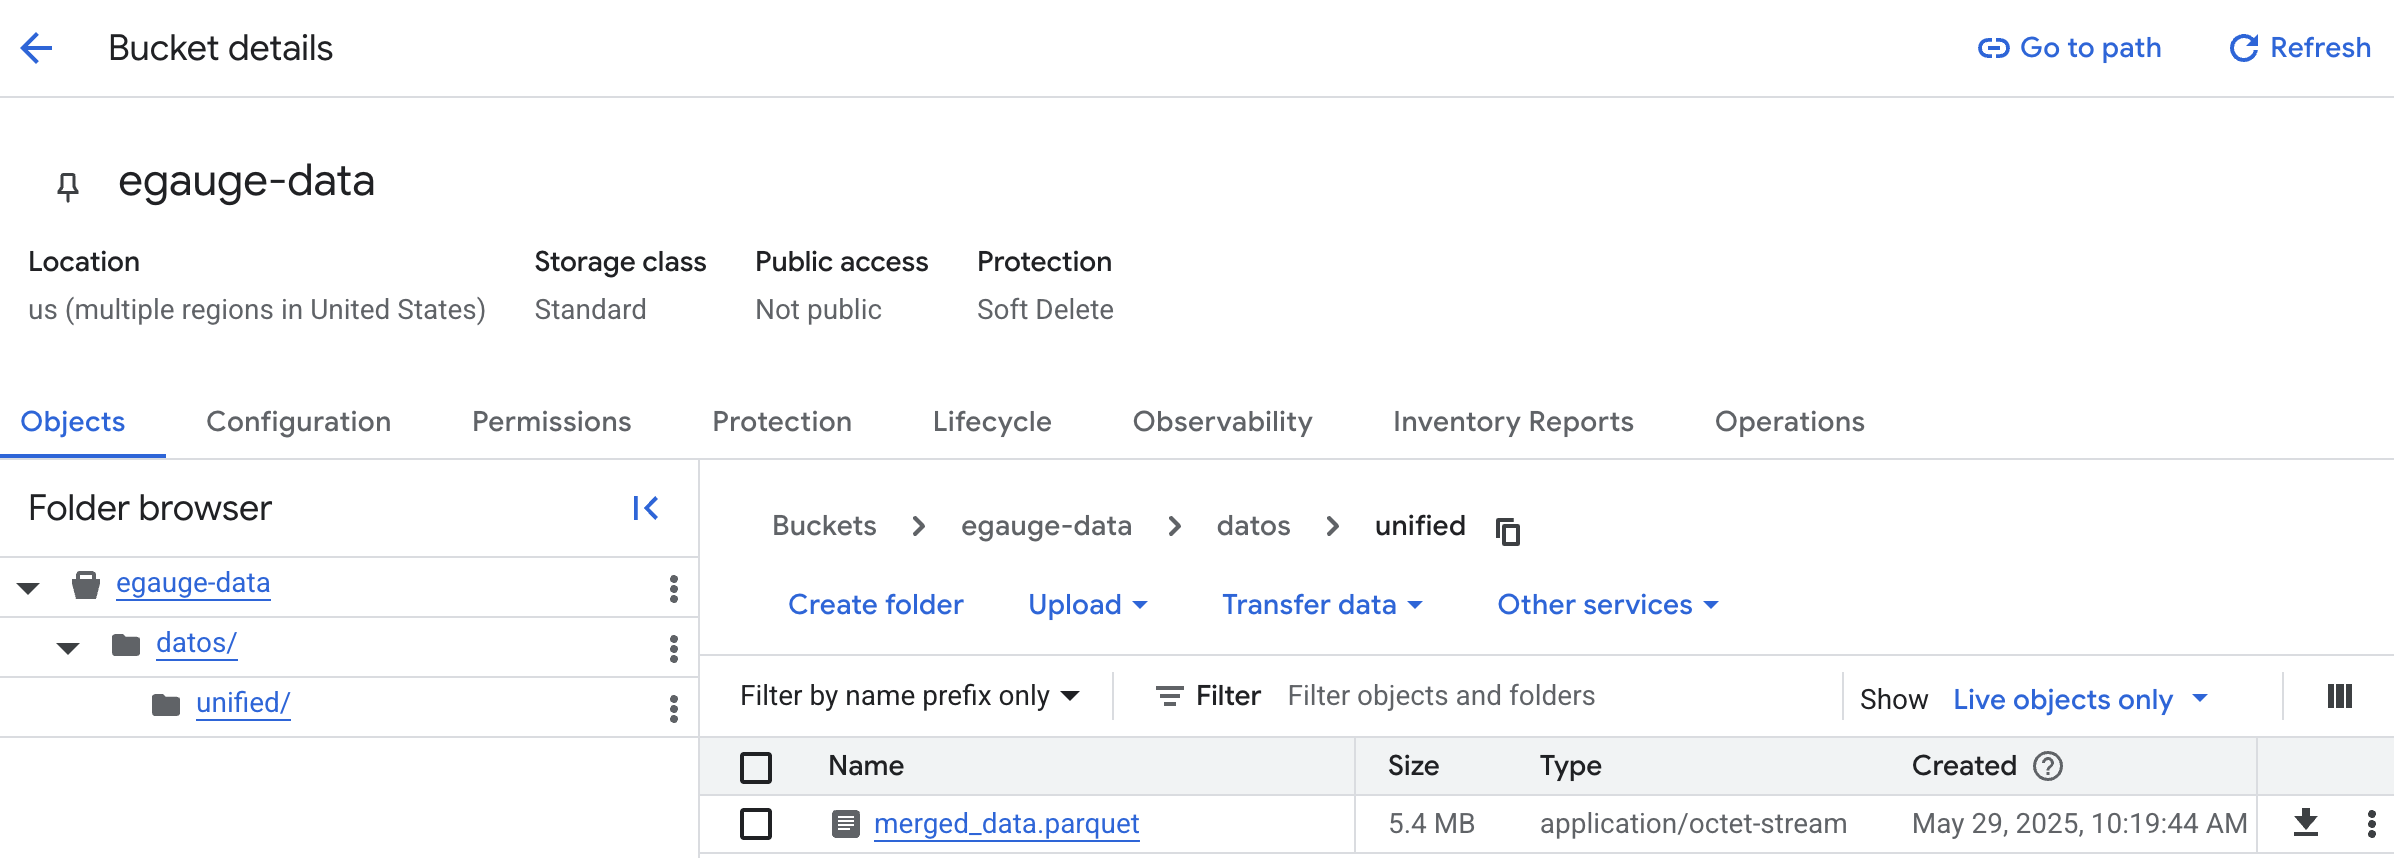

In [19]:
# Show screenshot GCS
display(Image(filename="screenshots/gcs.png"))

*NOTE: GCS timestamp shows Spain timezone but the eGauge data logs are in Costa Rica timezone, which is -8h from Spain's (-7h during summer).*

We can then use BigQuery to retrieve the latest file from GCS to be integrated with visualization platforms like Power BI:

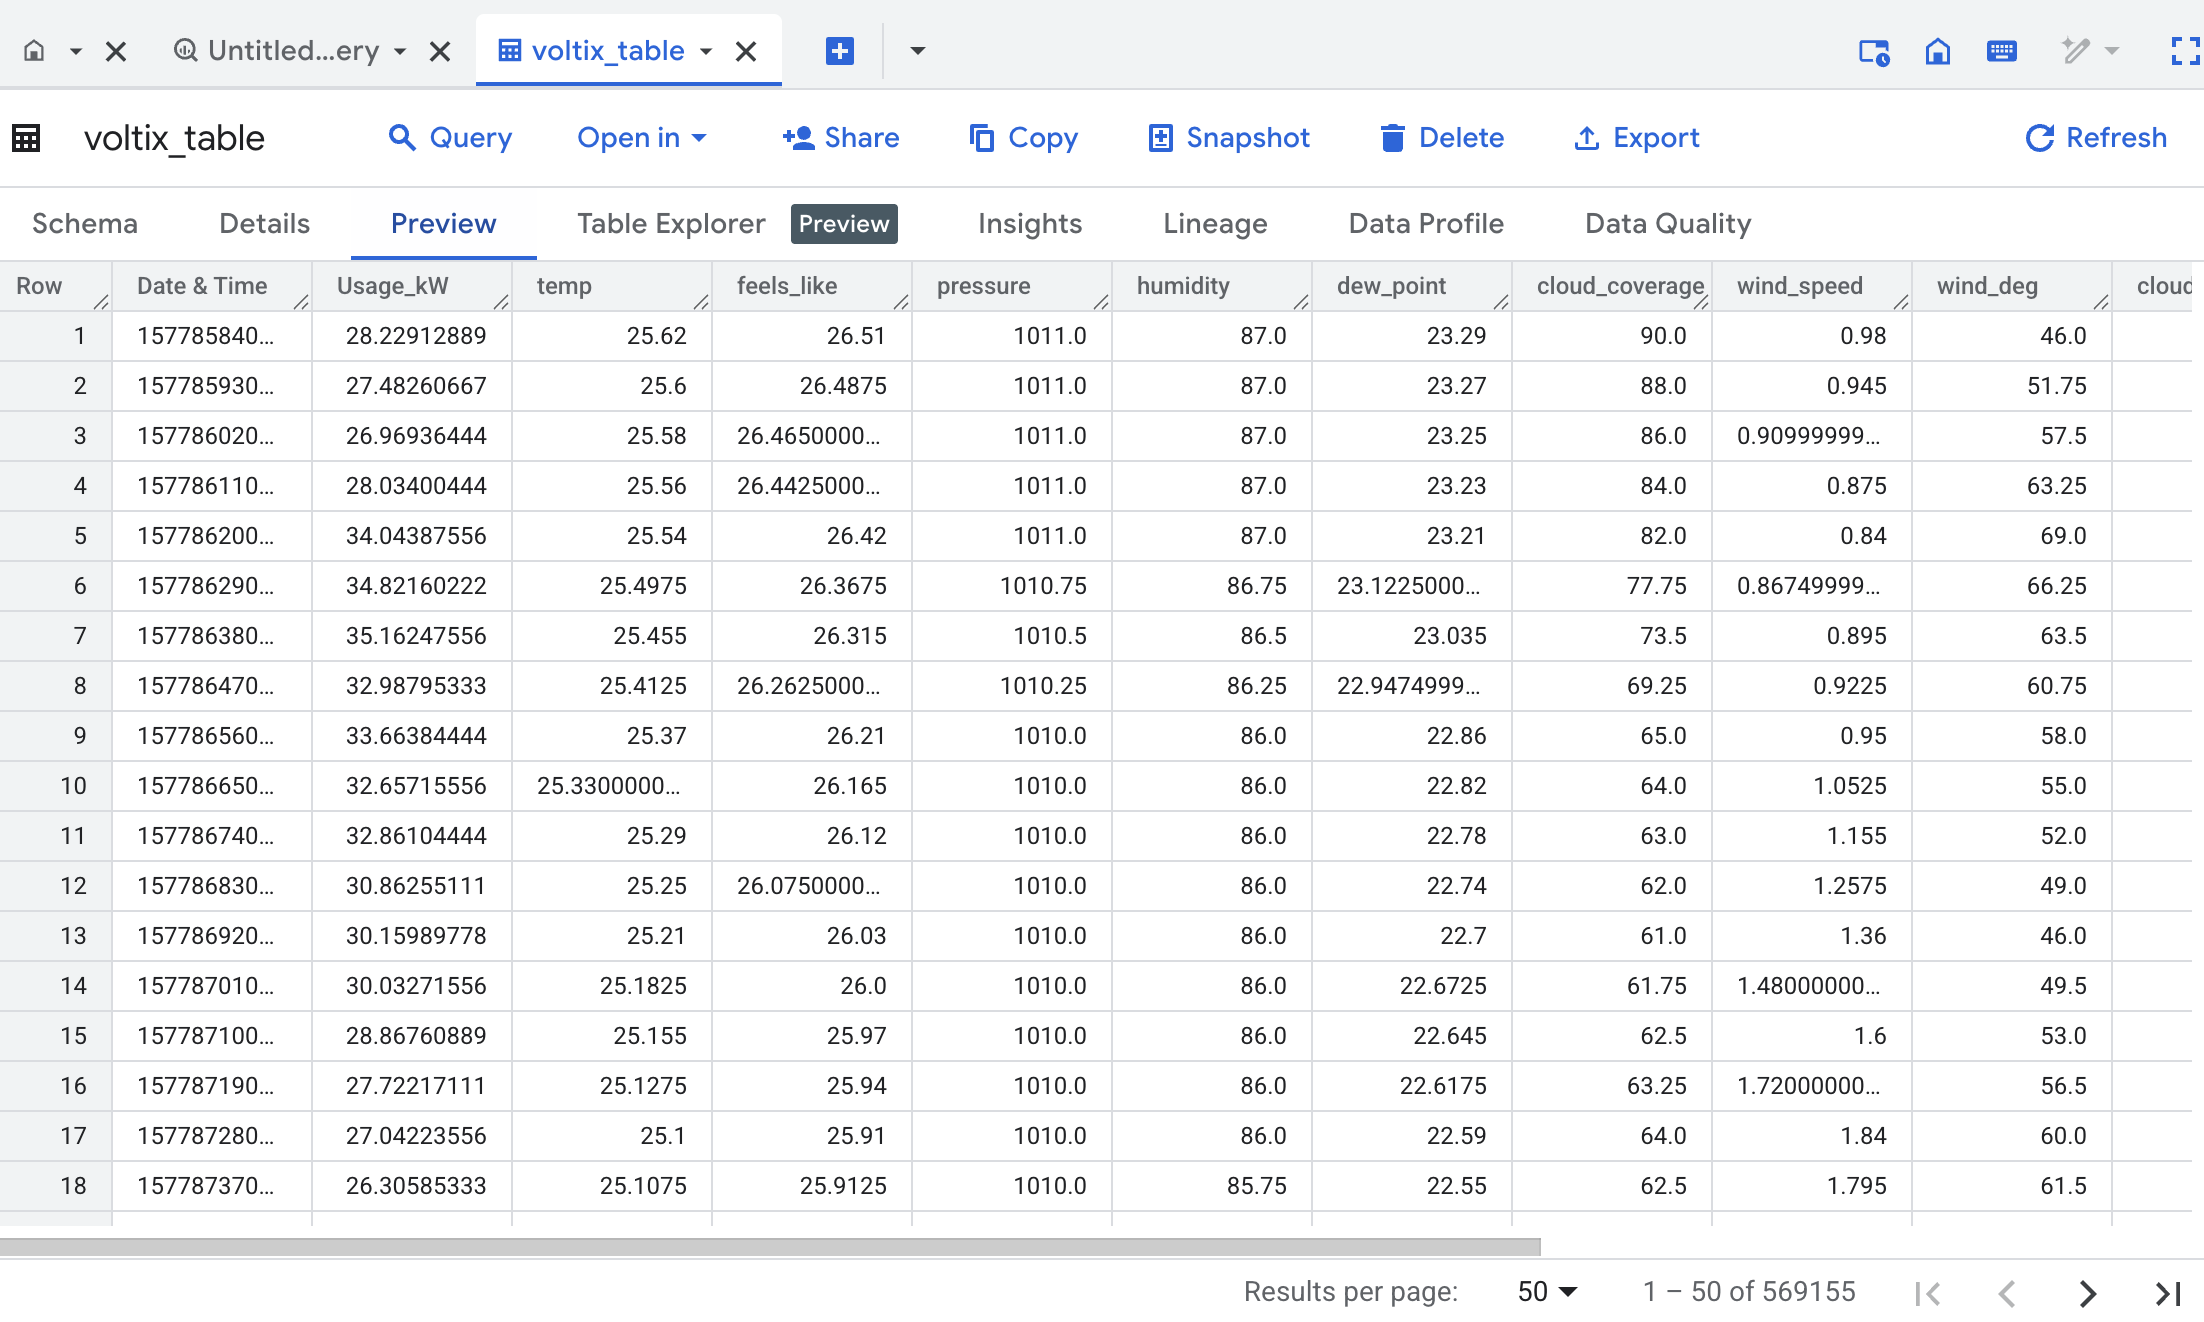

In [27]:
# Show screenshot BQ
display(Image(filename="screenshots/bq.png"))